# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [2748]:
# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only show errors

import pandas as pd
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout,LSTM, GRU,TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2749]:
# Define a function to load data and aggregate them

def load_and_aggregate_stock_data(file_list):
    """
    Loads and aggregates stock data from a list of CSV files.

    Parameters:
        file_list (list of str): List of file paths to CSV files.

    Returns:
        pd.DataFrame: A single DataFrame containing aggregated stock data.
    """
    data_frames = []

    for file_path in file_list:
        # Extract stock name from file name (e.g., "AAPL.csv" → "AAPL")
        stock_name = os.path.splitext(os.path.basename(file_path))[0]

        # Read CSV into DataFrame
        df = pd.read_csv(file_path)

        # Add stock name to column names (except for 'Date')
        df = df.rename(columns={col: f"{stock_name}_{col}" if col != 'Date' else col for col in df.columns})

        # Drop unnecessary columns (keep 'Date' and relevant numeric fields)
        # Adjust this based on which columns are actually in the CSV
        necessary_columns = [col for col in df.columns if 'Date' in col or any(x in col for x in ['Open', 'Close', 'High', 'Low', 'Volume'])]
        df = df[necessary_columns]

        # Append DataFrame to the list
        data_frames.append(df)

    # Merge all data frames on the 'Date' column
    from functools import reduce
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), data_frames)

    # Optionally, sort by date
    merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

    return merged_df


In [2750]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
files = ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']
combined_df = load_and_aggregate_stock_data(files)
print(combined_df.head())


         Date  AMZN_stocks_data_Open  AMZN_stocks_data_High  \
0  2006-01-03                  47.47                  47.85   
1  2006-01-04                  47.48                  47.73   
2  2006-01-05                  47.16                  48.20   
3  2006-01-06                  47.97                  48.58   
4  2006-01-09                  46.55                  47.10   

   AMZN_stocks_data_Low  AMZN_stocks_data_Close  AMZN_stocks_data_Volume  \
0                 46.25                   47.58                7582127.0   
1                 46.69                   47.25                7440914.0   
2                 47.11                   47.65                5417258.0   
3                 47.32                   47.87                6154285.0   
4                 46.40                   47.08                8945056.0   

   GOOGL_stocks_data_Open  GOOGL_stocks_data_High  GOOGL_stocks_data_Low  \
0                  211.47                  218.05                 209.32   
1           

In [2751]:
# View specifics of the data
print(combined_df.describe())

# Basic structure and data types
print(combined_df.info())


       AMZN_stocks_data_Open  AMZN_stocks_data_High  AMZN_stocks_data_Low  \
count            3019.000000            3019.000000           3019.000000   
mean              299.335310             302.371163            296.037695   
std               280.120547             281.826442            277.927134   
min                26.090000              26.300000             25.760000   
25%                81.175000              82.580000             79.725000   
50%               205.330000             208.000000            202.100000   
75%               375.570000             379.155000            373.000000   
max              1204.880000            1213.410000           1191.150000   

       AMZN_stocks_data_Close  AMZN_stocks_data_Volume  \
count             3019.000000             3.019000e+03   
mean               299.376231             5.931712e+06   
std                279.980161             5.122034e+06   
min                 26.070000             9.864350e+05   
25%             

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [2752]:
# Handle Missing Values

combined_df.isnull().sum()

Date                        0
AMZN_stocks_data_Open       1
AMZN_stocks_data_High       1
AMZN_stocks_data_Low        1
AMZN_stocks_data_Close      1
AMZN_stocks_data_Volume     1
GOOGL_stocks_data_Open      1
GOOGL_stocks_data_High      1
GOOGL_stocks_data_Low       1
GOOGL_stocks_data_Close     1
GOOGL_stocks_data_Volume    1
IBM_stocks_data_Open        1
IBM_stocks_data_High        0
IBM_stocks_data_Low         1
IBM_stocks_data_Close       0
IBM_stocks_data_Volume      0
MSFT_stocks_data_Open       1
MSFT_stocks_data_High       1
MSFT_stocks_data_Low        1
MSFT_stocks_data_Close      1
MSFT_stocks_data_Volume     1
dtype: int64

In [2753]:
#handle missing data
combined_df = combined_df.dropna()


In [2754]:
#checking missing or null values
combined_df.isnull().sum()

Date                        0
AMZN_stocks_data_Open       0
AMZN_stocks_data_High       0
AMZN_stocks_data_Low        0
AMZN_stocks_data_Close      0
AMZN_stocks_data_Volume     0
GOOGL_stocks_data_Open      0
GOOGL_stocks_data_High      0
GOOGL_stocks_data_Low       0
GOOGL_stocks_data_Close     0
GOOGL_stocks_data_Volume    0
IBM_stocks_data_Open        0
IBM_stocks_data_High        0
IBM_stocks_data_Low         0
IBM_stocks_data_Close       0
IBM_stocks_data_Volume      0
MSFT_stocks_data_Open       0
MSFT_stocks_data_High       0
MSFT_stocks_data_Low        0
MSFT_stocks_data_Close      0
MSFT_stocks_data_Volume     0
dtype: int64

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

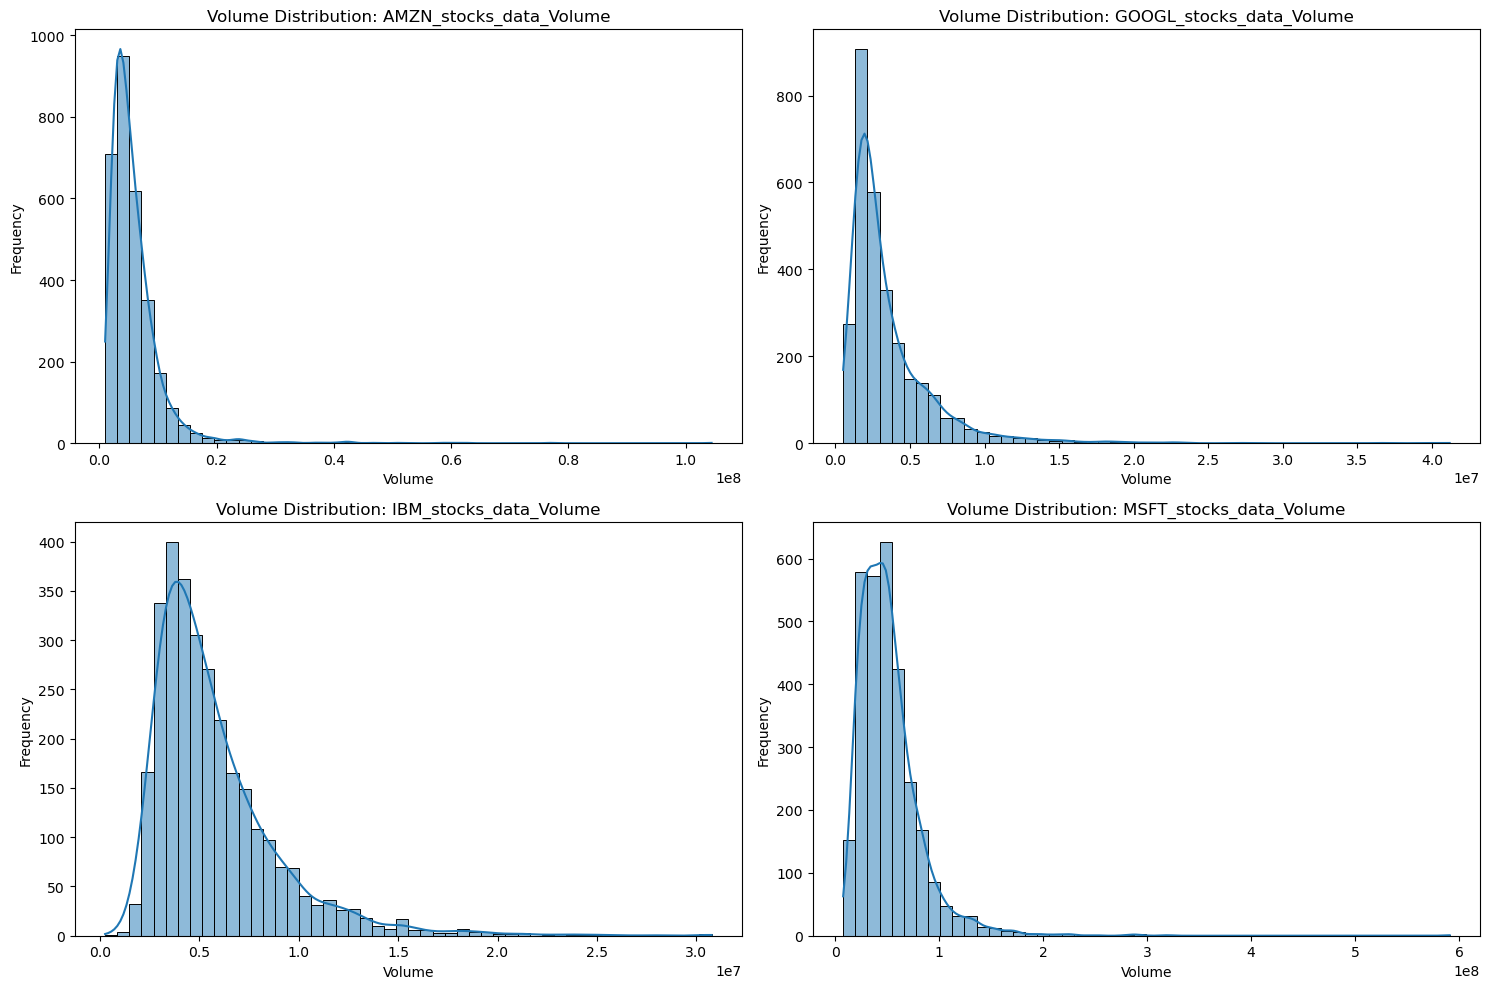

In [2755]:
# Frequency distribution of volumes


# Extract volume columns
volume_columns = [col for col in combined_df.columns if 'Volume' in col]

# Plot frequency distribution (histograms) for each stock's volume
plt.figure(figsize=(15, 10))
for i, col in enumerate(volume_columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(combined_df[col].dropna(), bins=50, kde=True)
    plt.title(f'Volume Distribution: {col}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [2756]:
combined_df.head()

,Date,AMZN_stocks_data_Open,AMZN_stocks_data_High,AMZN_stocks_data_Low,AMZN_stocks_data_Close,AMZN_stocks_data_Volume,GOOGL_stocks_data_Open,GOOGL_stocks_data_High,GOOGL_stocks_data_Low,GOOGL_stocks_data_Close,...,IBM_stocks_data_Open,IBM_stocks_data_High,IBM_stocks_data_Low,IBM_stocks_data_Close,IBM_stocks_data_Volume,MSFT_stocks_data_Open,MSFT_stocks_data_High,MSFT_stocks_data_Low,MSFT_stocks_data_Close,MSFT_stocks_data_Volume
0,2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,...,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418.0
1,2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,...,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661.0
2,2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,...,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610.0
3,2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,...,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092.0
4,2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,...,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836.0


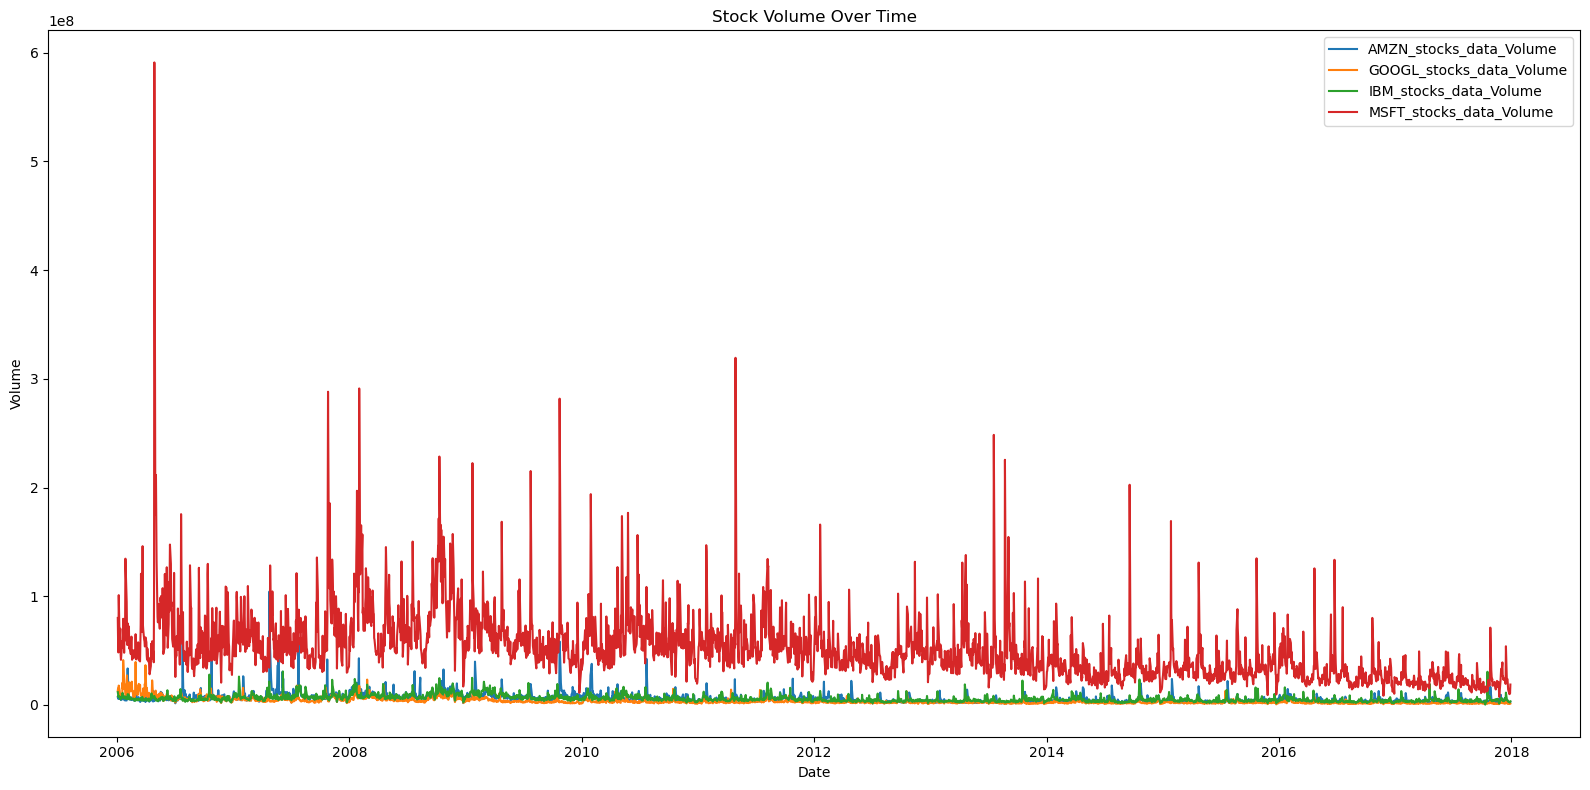

In [2757]:
# Stock volume variation over time

# Convert 'Date' to datetime if not already
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Set date as index for time series plot
df_volumes_time = combined_df.set_index('Date')[volume_columns]

# Plot volume over time
plt.figure(figsize=(16, 8))
for col in volume_columns:
    plt.plot(df_volumes_time.index, df_volumes_time[col], label=col)

plt.title('Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

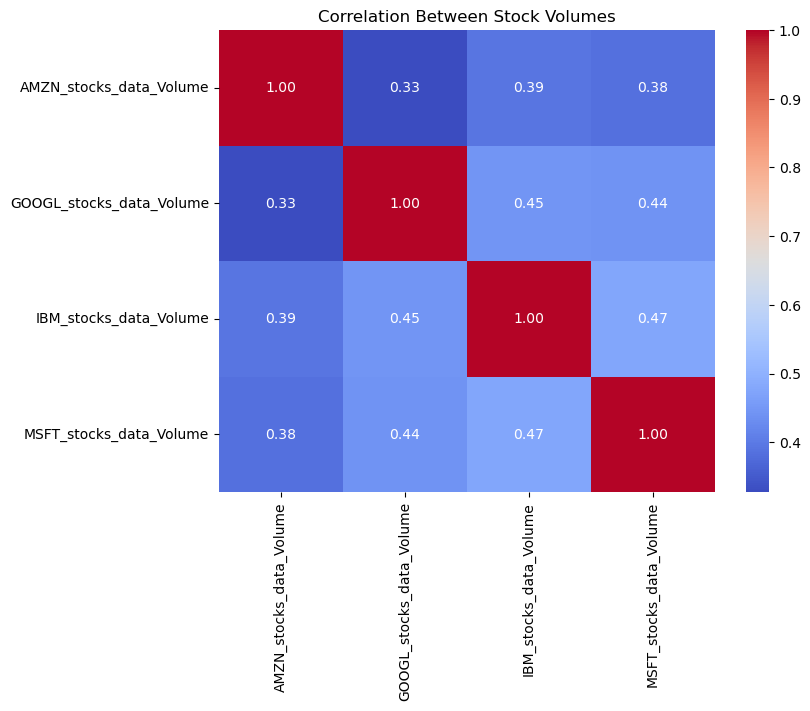

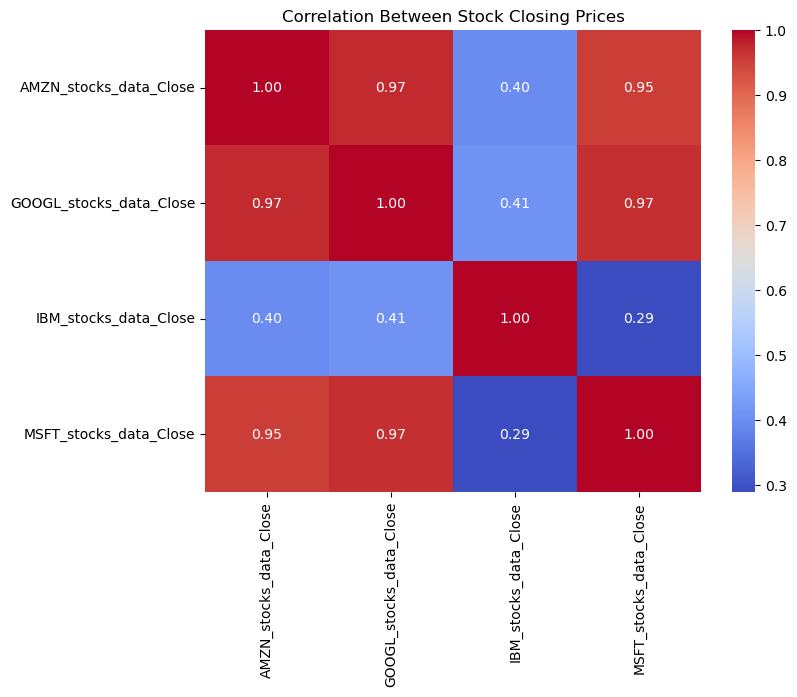

In [2758]:
# Analyse correlations

#Correlation among volume columns
volume_columns = [col for col in combined_df.columns if 'Volume' in col]
volume_data = combined_df[volume_columns]

# Correlation among closing price columns
close_columns = [col for col in combined_df.columns if 'Close' in col]
close_data = combined_df[close_columns]

# Correlation for volumes
volume_corr = volume_data.corr()

# Correlation for closing prices
close_corr = close_data.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(volume_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Stock Volumes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(close_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Stock Closing Prices')
plt.show()



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [2759]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_data(df, window_size=20, step_size=1, target_names=['AMZN']):
    """
    Splits the dataframe into windowed X and y arrays for time series prediction.

    Args:
        df (pd.DataFrame): The master dataframe.
        window_size (int): Number of time steps in each window.
        step_size (int): Stride for moving the window.
        target_names (list): List of stock names whose 'Close' values to predict.

    Returns:
        X_windows (np.ndarray): Array of shape (num_windows, window_size, num_features).
        y_windows (np.ndarray): Array of shape (num_windows, num_targets).
    """
    # Use only numeric columns for features
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X_windows = []
    y_windows = []

    # Build target column names
    target_cols = [name for name in target_names]

    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        X_window = df.iloc[start:end][feature_cols].values
        y_window = df.iloc[end][target_cols].values if end < len(df) else None
        if y_window is not None:
            X_windows.append(X_window)
            y_windows.append(y_window)

    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows)
    return X_windows, y_windows


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [2760]:

def scale_windowed_data(X_windows, y_windows):
    """
    Scales windowed X and y data using StandardScaler.
    Each feature is scaled across all windows and time steps.

    Args:
        X_windows (np.ndarray): Shape (num_windows, window_size, num_features)
        y_windows (np.ndarray): Shape (num_windows, num_targets)

    Returns:
        X_scaled (np.ndarray): Scaled X_windows
        y_scaled (np.ndarray): Scaled y_windows
        X_scaler (StandardScaler): Fitted scaler for X
        y_scaler (StandardScaler): Fitted scaler for y
    """
    num_windows, window_size, num_features = X_windows.shape

    # Reshape X to 2D for scaling: (num_windows * window_size, num_features)
    X_reshaped = X_windows.reshape(-1, num_features)
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_windows, window_size, num_features)

    # Scale y
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y_windows)

    return X_scaled, y_scaled, X_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [2761]:
# Define a function to create input and output data points from the master DataFrame
def prepare_rnn_data(master_df, target_names, window_size=20, step_size=1, test_size=0.2):
    """
    Prepares scaled and windowed train/test data for RNNs.

    Args:
        master_df (pd.DataFrame): The joined master data set.
        target_names (list): List of stock names to predict (e.g., ['AMZN']).
        window_size (int): Number of time steps in each window.
        step_size (int): Stride for moving the window.
        test_size (float): Fraction of data to use as test set.

    Returns:
        X_train, y_train, X_test, y_test: Scaled and split data ready for RNNs.
    """
    # Create windowed data
    X_windows, y_windows = create_windowed_data(
        master_df, window_size=window_size, step_size=step_size, target_names=target_names
    )

    # Split into train and test sets (no shuffling for time series)
    # We do not use train_test_split because time series data must preserve temporal order.
    # Shuffling would cause data leakage from future to past.
    # Instead, we split sequentially: the first part for training, the last part for testing.
    split_idx = int((1 - test_size) * len(X_windows))
    X_train, X_test = X_windows[:split_idx], X_windows[split_idx:]
    y_train, y_test = y_windows[:split_idx], y_windows[split_idx:]

    # Scale the data
    X_train_scaled, y_train_scaled, X_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    # Use the same scalers to transform test data
    num_windows_test, window_size_test, num_features = X_test.shape
    X_test_reshaped = X_test.reshape(-1, num_features)
    X_test_scaled = X_scaler.transform(X_test_reshaped).reshape(num_windows_test, window_size_test, num_features)
    y_test_scaled = y_scaler.transform(y_test)

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled,X_scaler, y_scaler 


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df[column].resample('M').mean()
/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df[column].resample('Q').mean()


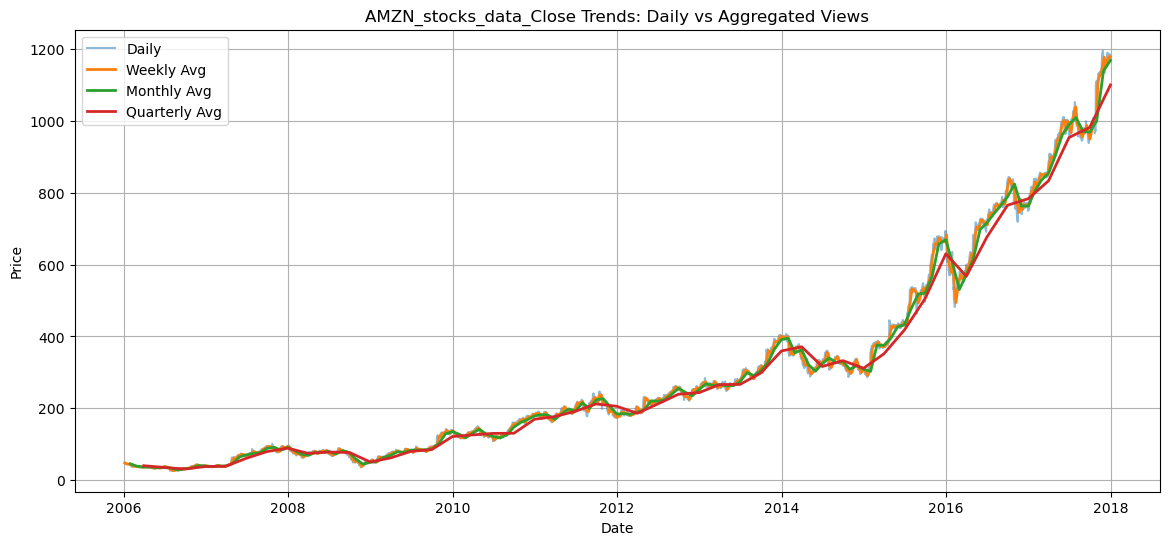

/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df[column].resample('M').mean()
/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df[column].resample('Q').mean()


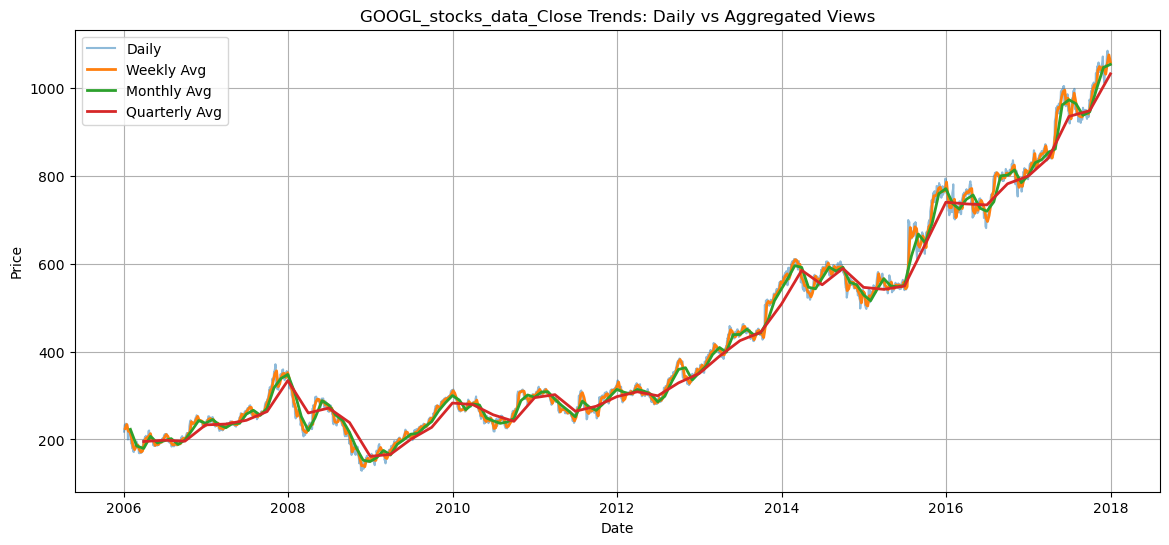

/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df[column].resample('M').mean()
/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df[column].resample('Q').mean()


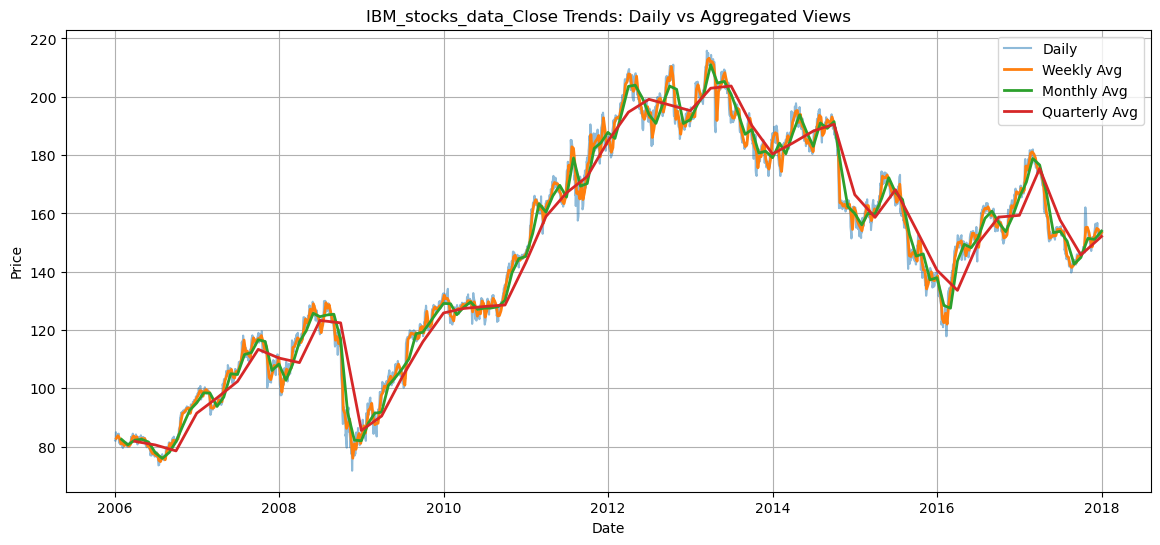

/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df[column].resample('M').mean()
/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/2446868150.py:20: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df[column].resample('Q').mean()


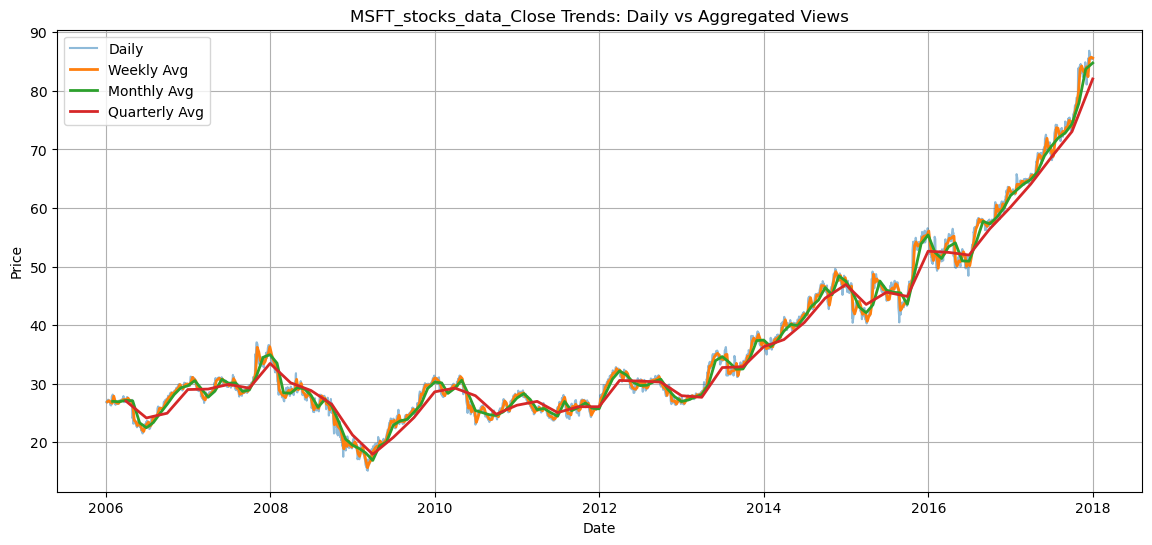

In [2762]:
# Checking for patterns in different sequence lengths

def plot_resampled_trends(df, column, date_col='Date'):
    """
    Plot trends in the given column for weekly, monthly, and quarterly resampling.

    Parameters:
    - df: DataFrame with date and stock price columns
    - column: Column name of stock price (e.g., 'AMZN_Close')
    - date_col: Column name of the date column (default 'Date')
    """
    # Ensure date column is datetime type and set as index
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    
    # Resampling
    weekly = df[column].resample('W').mean()
    monthly = df[column].resample('M').mean()
    quarterly = df[column].resample('Q').mean()

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(df[column], label='Daily', alpha=0.5)
    plt.plot(weekly, label='Weekly Avg', linewidth=2)
    plt.plot(monthly, label='Monthly Avg', linewidth=2)
    plt.plot(quarterly, label='Quarterly Avg', linewidth=2)
    plt.title(f'{column} Trends: Daily vs Aggregated Views')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

stock_columns = ['AMZN_stocks_data_Close', 'GOOGL_stocks_data_Close', 'IBM_stocks_data_Close', 'MSFT_stocks_data_Close']

for stock in stock_columns:
    plot_resampled_trends(combined_df, stock)



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [2763]:
combined_df.columns

Index(['Date', 'AMZN_stocks_data_Open', 'AMZN_stocks_data_High',
       'AMZN_stocks_data_Low', 'AMZN_stocks_data_Close',
       'AMZN_stocks_data_Volume', 'GOOGL_stocks_data_Open',
       'GOOGL_stocks_data_High', 'GOOGL_stocks_data_Low',
       'GOOGL_stocks_data_Close', 'GOOGL_stocks_data_Volume',
       'IBM_stocks_data_Open', 'IBM_stocks_data_High', 'IBM_stocks_data_Low',
       'IBM_stocks_data_Close', 'IBM_stocks_data_Volume',
       'MSFT_stocks_data_Open', 'MSFT_stocks_data_High',
       'MSFT_stocks_data_Low', 'MSFT_stocks_data_Close',
       'MSFT_stocks_data_Volume'],
      dtype='object')

In [2764]:
# Decide on window size and step size based on previous analysis
window_size = 63
step_size = 1  

# Prepare data for predicting AMZN closing price
target_names=['AMZN_stocks_data_Close', 'GOOGL_stocks_data_Close', 'IBM_stocks_data_Close', 'MSFT_stocks_data_Close']

X_train, y_train, X_test, y_test,X_scaler, y_scaler  = prepare_rnn_data(
    combined_df,
    target_names=target_names,
    window_size=window_size,
    step_size=step_size,
    test_size=0.2
)



In [2765]:
# Check the number of data points generated

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2364, 63, 20), (591, 63, 20), (2364, 4), (591, 4))

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [2766]:
# Check the number of data points generated
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])
print("Shape of each training sample (window):", X_train.shape[1:])
print("Shape of each testing sample (window):", X_test.shape[1:])

Number of training samples: 2364
Number of testing samples: 591
Shape of each training sample (window): (63, 20)
Shape of each testing sample (window): (63, 20)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [2767]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_rnn_model(input_shape, output_dim, units=50, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=input_shape, activation='linear'))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim))  # Linear activation by default for regression

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [2768]:
# Find an optimal configuration of simple RNN

def tune_rnn(X_train, y_train, X_test, y_test, param_grid):
    best_model = None
    best_val_loss = float('inf')
    best_params = None

    for units in param_grid['units']:
        for dropout in param_grid['dropout']:
            for lr in param_grid['lr']:
                print(f"Training RNN with units={units}, dropout={dropout}, lr={lr}")
                model = build_rnn_model(
                    input_shape=X_train.shape[1:], 
                    output_dim=y_train.shape[1],
                    units=units,
                    dropout=dropout,
                    lr=lr
                )

                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,  # You can increase if needed
                    batch_size=32,
                    verbose=2
                )

                val_loss = min(history.history['val_loss'])
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'units': units, 'dropout': dropout, 'lr': lr}
    
    print("Best Parameters:", best_params)
    return best_model, best_params


In [2769]:
# Find the best configuration based on evaluation metrics
param_grid = {
    'units': [32, 64,128],
    'dropout': [0.2, 0.25,0.30],
    'lr': [0.001, 0.0003,0.0005]
}
best_model, best_params=tune_rnn(X_train, y_train, X_test, y_test, param_grid)
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")



Training RNN with units=32, dropout=0.2, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 5.6611 - mae: 1.6131 - val_loss: 12.9756 - val_mae: 3.2597 - 567ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 1.6450 - mae: 0.9600 - val_loss: 8.2173 - val_mae: 2.5796 - 233ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 1.1393 - mae: 0.7993 - val_loss: 5.7153 - val_mae: 2.1891 - 230ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 0.8346 - mae: 0.6890 - val_loss: 4.1845 - val_mae: 1.8618 - 228ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 0.6940 - mae: 0.6239 - val_loss: 3.1387 - val_mae: 1.6323 - 229ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 0.5647 - mae: 0.5567 - val_loss: 2.2799 - val_mae: 1.3820 - 225ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 0.4688 - mae: 0.5135 - val_loss: 2.1290 - val_mae: 1.3560 - 225ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3967 - mae: 0.4685 - val_loss: 1.6332 - val_mae: 1.1662 - 225ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 0.3407 - mae: 0

Training RNN with units=32, dropout=0.2, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 7.7628 - mae: 2.0164 - val_loss: 24.9606 - val_mae: 4.1194 - 587ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 3.0921 - mae: 1.3226 - val_loss: 16.4797 - val_mae: 3.4163 - 235ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 2.0832 - mae: 1.0865 - val_loss: 11.3373 - val_mae: 2.8312 - 240ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 1.6273 - mae: 0.9602 - val_loss: 8.3447 - val_mae: 2.4572 - 238ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 1.2969 - mae: 0.8510 - val_loss: 6.6153 - val_mae: 2.1592 - 304ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 1.1318 - mae: 0.7881 - val_loss: 4.9997 - val_mae: 1.8007 - 239ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 0.9374 - mae: 0.7259 - val_loss: 4.5424 - val_mae: 1.7060 - 235ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 0.8555 - mae: 0.6885 - val_loss: 3.6560 - val_mae: 1.5202 - 234ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 0.7669 - mae

Training RNN with units=32, dropout=0.2, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 12.5490 - mae: 2.5028 - val_loss: 14.5561 - val_mae: 3.1892 - 569ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 4.1934 - mae: 1.5540 - val_loss: 6.6770 - val_mae: 2.2545 - 226ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 2.7178 - mae: 1.2448 - val_loss: 4.2701 - val_mae: 1.8032 - 229ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 1.9685 - mae: 1.0602 - val_loss: 2.6378 - val_mae: 1.3879 - 228ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 1.5820 - mae: 0.9530 - val_loss: 1.8256 - val_mae: 1.0984 - 229ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 1.2571 - mae: 0.8459 - val_loss: 0.9228 - val_mae: 0.7558 - 225ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 1.1366 - mae: 0.8010 - val_loss: 0.8986 - val_mae: 0.7363 - 225ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 0.9759 - mae: 0.7419 - val_loss: 0.8616 - val_mae: 0.7199 - 224ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 0.8484 - mae:

Training RNN with units=32, dropout=0.25, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 10.0623 - mae: 2.1910 - val_loss: 10.3032 - val_mae: 2.5070 - 562ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 3.0088 - mae: 1.3187 - val_loss: 4.6255 - val_mae: 1.8715 - 230ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 1.9158 - mae: 1.0424 - val_loss: 2.6452 - val_mae: 1.2908 - 230ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 1.4344 - mae: 0.8995 - val_loss: 3.0306 - val_mae: 1.3527 - 231ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 1.1767 - mae: 0.8147 - val_loss: 2.0788 - val_mae: 1.1214 - 230ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 0.9404 - mae: 0.7287 - val_loss: 2.0028 - val_mae: 1.0650 - 226ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 0.7813 - mae: 0.6596 - val_loss: 1.7217 - val_mae: 1.0146 - 226ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 0.6700 - mae: 0.6180 - val_loss: 1.6335 - val_mae: 0.9846 - 226ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 0.5710 - mae:

Training RNN with units=32, dropout=0.25, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 9.6656 - mae: 2.2245 - val_loss: 13.9773 - val_mae: 3.2086 - 562ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 3.5301 - mae: 1.4169 - val_loss: 9.1238 - val_mae: 2.5674 - 234ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 2.4717 - mae: 1.1881 - val_loss: 5.6565 - val_mae: 2.0111 - 231ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 1.8936 - mae: 1.0393 - val_loss: 3.8199 - val_mae: 1.6245 - 231ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 1.5098 - mae: 0.9341 - val_loss: 2.5557 - val_mae: 1.2873 - 230ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 1.2913 - mae: 0.8552 - val_loss: 1.7674 - val_mae: 1.0558 - 258ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 1.1142 - mae: 0.7926 - val_loss: 1.2697 - val_mae: 0.8955 - 285ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 1.0031 - mae: 0.7522 - val_loss: 0.9818 - val_mae: 0.7790 - 261ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.8987 - mae:

Training RNN with units=32, dropout=0.25, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 11.1328 - mae: 2.3541 - val_loss: 8.8929 - val_mae: 2.4492 - 595ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 3.4667 - mae: 1.4045 - val_loss: 4.2451 - val_mae: 1.5951 - 303ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 2.2869 - mae: 1.1213 - val_loss: 3.1438 - val_mae: 1.2729 - 270ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 1.7130 - mae: 0.9769 - val_loss: 2.3839 - val_mae: 1.1017 - 312ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 1.3721 - mae: 0.8753 - val_loss: 2.0050 - val_mae: 1.0214 - 239ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 1.1688 - mae: 0.8037 - val_loss: 1.6953 - val_mae: 0.9582 - 228ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 0.9841 - mae: 0.7401 - val_loss: 1.3701 - val_mae: 0.8596 - 229ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 0.8564 - mae: 0.6854 - val_loss: 1.2117 - val_mae: 0.8116 - 238ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 0.7425 - mae:

Training RNN with units=32, dropout=0.3, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 11.5914 - mae: 2.2342 - val_loss: 2.8703 - val_mae: 1.4077 - 582ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 2.8168 - mae: 1.2770 - val_loss: 2.2334 - val_mae: 1.2500 - 239ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 1.9179 - mae: 1.0410 - val_loss: 1.8896 - val_mae: 1.0794 - 231ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 1.3931 - mae: 0.8818 - val_loss: 1.9531 - val_mae: 1.0717 - 242ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 1.1046 - mae: 0.7900 - val_loss: 1.7065 - val_mae: 0.9781 - 240ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 0.8878 - mae: 0.7115 - val_loss: 1.4957 - val_mae: 0.9199 - 237ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 0.7481 - mae: 0.6518 - val_loss: 1.4580 - val_mae: 0.9160 - 240ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 0.6612 - mae: 0.6059 - val_loss: 1.0556 - val_mae: 0.7994 - 239ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 0.5645 - mae: 0

Training RNN with units=32, dropout=0.3, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 10.8127 - mae: 2.4375 - val_loss: 8.0416 - val_mae: 2.2852 - 584ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 4.5778 - mae: 1.6330 - val_loss: 5.2308 - val_mae: 1.8835 - 250ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 3.0885 - mae: 1.3309 - val_loss: 3.4277 - val_mae: 1.4734 - 255ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 2.3908 - mae: 1.1677 - val_loss: 3.5947 - val_mae: 1.5309 - 248ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 1.9865 - mae: 1.0582 - val_loss: 3.3981 - val_mae: 1.4968 - 239ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 1.6215 - mae: 0.9521 - val_loss: 2.8662 - val_mae: 1.3557 - 245ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 1.3782 - mae: 0.8759 - val_loss: 2.8001 - val_mae: 1.3318 - 248ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 1.2120 - mae: 0.8211 - val_loss: 3.0621 - val_mae: 1.3821 - 244ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 1.0357 - mae: 

Training RNN with units=32, dropout=0.3, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 23.6232 - mae: 3.3255 - val_loss: 45.7710 - val_mae: 5.7079 - 561ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 6.9444 - mae: 2.0117 - val_loss: 24.3909 - val_mae: 4.1509 - 247ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 4.3999 - mae: 1.6025 - val_loss: 17.6962 - val_mae: 3.5166 - 248ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 3.1302 - mae: 1.3533 - val_loss: 14.0438 - val_mae: 3.1025 - 230ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 2.4979 - mae: 1.2059 - val_loss: 11.2157 - val_mae: 2.7484 - 227ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 1.9958 - mae: 1.0733 - val_loss: 8.8713 - val_mae: 2.3720 - 224ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 1.6674 - mae: 0.9744 - val_loss: 7.6545 - val_mae: 2.1975 - 224ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 1.4507 - mae: 0.9066 - val_loss: 6.4518 - val_mae: 1.9896 - 227ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 1.2174 - 

Training RNN with units=64, dropout=0.2, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 4.9177 - mae: 1.4863 - val_loss: 3.8450 - val_mae: 1.5592 - 603ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 1.2119 - mae: 0.8292 - val_loss: 2.1843 - val_mae: 1.1625 - 284ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 0.7557 - mae: 0.6559 - val_loss: 1.1514 - val_mae: 0.8619 - 286ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 0.5247 - mae: 0.5513 - val_loss: 0.6381 - val_mae: 0.6360 - 289ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 0.4087 - mae: 0.4848 - val_loss: 0.5440 - val_mae: 0.5590 - 285ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 0.3303 - mae: 0.4366 - val_loss: 0.4821 - val_mae: 0.5453 - 284ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.2714 - mae: 0.3919 - val_loss: 0.3586 - val_mae: 0.4603 - 282ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 0.2263 - mae: 0.3608 - val_loss: 0.2010 - val_mae: 0.3674 - 283ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.1970 - mae: 0.

Training RNN with units=64, dropout=0.2, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 6.9478 - mae: 1.9028 - val_loss: 2.9823 - val_mae: 1.2782 - 668ms/epoch - 9ms/step
Epoch 2/20
74/74 - 0s - loss: 2.4247 - mae: 1.1870 - val_loss: 1.0026 - val_mae: 0.7784 - 304ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 1.6251 - mae: 0.9644 - val_loss: 1.2235 - val_mae: 0.8983 - 326ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 1.2166 - mae: 0.8361 - val_loss: 0.6078 - val_mae: 0.6106 - 441ms/epoch - 6ms/step
Epoch 5/20
74/74 - 0s - loss: 0.9768 - mae: 0.7413 - val_loss: 0.6026 - val_mae: 0.6097 - 311ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 0.7986 - mae: 0.6756 - val_loss: 0.3658 - val_mae: 0.4673 - 290ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.6994 - mae: 0.6257 - val_loss: 0.2936 - val_mae: 0.4156 - 289ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 0.5851 - mae: 0.5745 - val_loss: 0.2460 - val_mae: 0.3761 - 302ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.5096 - mae: 0

Training RNN with units=64, dropout=0.2, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 15.2893 - mae: 2.3814 - val_loss: 16.1816 - val_mae: 3.4908 - 651ms/epoch - 9ms/step
Epoch 2/20
74/74 - 0s - loss: 3.1049 - mae: 1.3433 - val_loss: 10.8665 - val_mae: 2.8093 - 321ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 2.1634 - mae: 1.1173 - val_loss: 6.8279 - val_mae: 2.2104 - 307ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 1.6118 - mae: 0.9680 - val_loss: 4.5281 - val_mae: 1.8443 - 307ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 1.3417 - mae: 0.8793 - val_loss: 3.1003 - val_mae: 1.5239 - 311ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 1.1139 - mae: 0.8041 - val_loss: 2.3151 - val_mae: 1.3169 - 317ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.9375 - mae: 0.7387 - val_loss: 1.6742 - val_mae: 1.1096 - 308ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 0.8271 - mae: 0.6892 - val_loss: 1.6200 - val_mae: 1.0821 - 296ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.7244 - mae

Training RNN with units=64, dropout=0.25, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 4.9579 - mae: 1.4731 - val_loss: 5.8626 - val_mae: 1.8784 - 634ms/epoch - 9ms/step
Epoch 2/20
74/74 - 0s - loss: 1.1120 - mae: 0.8038 - val_loss: 3.3055 - val_mae: 1.4835 - 317ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 0.7272 - mae: 0.6502 - val_loss: 1.6067 - val_mae: 1.0061 - 313ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 0.5326 - mae: 0.5524 - val_loss: 1.1062 - val_mae: 0.8182 - 319ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 0.4234 - mae: 0.4917 - val_loss: 1.0696 - val_mae: 0.7968 - 311ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 0.3435 - mae: 0.4438 - val_loss: 0.7974 - val_mae: 0.6626 - 304ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.2915 - mae: 0.4097 - val_loss: 0.6637 - val_mae: 0.6045 - 314ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 0.2523 - mae: 0.3788 - val_loss: 0.6346 - val_mae: 0.6099 - 311ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.2240 - mae: 0

Training RNN with units=64, dropout=0.25, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 6.3227 - mae: 1.7921 - val_loss: 5.4287 - val_mae: 1.9393 - 645ms/epoch - 9ms/step
Epoch 2/20
74/74 - 0s - loss: 2.3609 - mae: 1.1580 - val_loss: 2.6847 - val_mae: 1.2869 - 303ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 1.6491 - mae: 0.9677 - val_loss: 1.8522 - val_mae: 1.0594 - 324ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 1.2644 - mae: 0.8439 - val_loss: 1.3695 - val_mae: 0.9207 - 328ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 1.0232 - mae: 0.7547 - val_loss: 1.0988 - val_mae: 0.7847 - 297ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 0.8443 - mae: 0.6887 - val_loss: 0.8495 - val_mae: 0.6555 - 286ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.7291 - mae: 0.6421 - val_loss: 0.8436 - val_mae: 0.6542 - 289ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 0.6321 - mae: 0.5992 - val_loss: 0.8303 - val_mae: 0.6523 - 286ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.5489 - mae: 

Training RNN with units=64, dropout=0.25, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 10.3084 - mae: 2.1668 - val_loss: 7.4746 - val_mae: 2.2375 - 632ms/epoch - 9ms/step
Epoch 2/20
74/74 - 0s - loss: 2.8974 - mae: 1.2742 - val_loss: 3.1603 - val_mae: 1.4928 - 304ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 1.9719 - mae: 1.0437 - val_loss: 1.6125 - val_mae: 1.0043 - 294ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 1.3817 - mae: 0.8775 - val_loss: 1.5484 - val_mae: 0.9670 - 288ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 1.1360 - mae: 0.7998 - val_loss: 1.0822 - val_mae: 0.8102 - 287ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 0.9426 - mae: 0.7243 - val_loss: 0.6941 - val_mae: 0.6394 - 286ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.8322 - mae: 0.6743 - val_loss: 0.6167 - val_mae: 0.6271 - 304ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 0.7050 - mae: 0.6262 - val_loss: 0.4904 - val_mae: 0.5424 - 308ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.6107 - mae:

Training RNN with units=64, dropout=0.3, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 6.4873 - mae: 1.7190 - val_loss: 3.7692 - val_mae: 1.6115 - 643ms/epoch - 9ms/step
Epoch 2/20
74/74 - 0s - loss: 1.6340 - mae: 0.9720 - val_loss: 2.2148 - val_mae: 1.2189 - 294ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 1.0746 - mae: 0.7881 - val_loss: 2.2677 - val_mae: 1.2044 - 289ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 0.7982 - mae: 0.6759 - val_loss: 1.7623 - val_mae: 1.0554 - 287ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 0.6260 - mae: 0.6012 - val_loss: 1.5434 - val_mae: 0.9475 - 287ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 0.5166 - mae: 0.5397 - val_loss: 1.1880 - val_mae: 0.9105 - 286ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 0.4333 - mae: 0.5016 - val_loss: 0.9285 - val_mae: 0.7853 - 338ms/epoch - 5ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3726 - mae: 0.4628 - val_loss: 0.5953 - val_mae: 0.6278 - 284ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.3281 - mae: 0.

Training RNN with units=64, dropout=0.3, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 13.9152 - mae: 2.5320 - val_loss: 24.2170 - val_mae: 4.1585 - 607ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 4.3890 - mae: 1.6022 - val_loss: 15.6563 - val_mae: 3.4173 - 288ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 3.1269 - mae: 1.3483 - val_loss: 9.0465 - val_mae: 2.5929 - 288ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 2.4594 - mae: 1.2024 - val_loss: 6.4689 - val_mae: 2.2177 - 286ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 1.9834 - mae: 1.0763 - val_loss: 4.2969 - val_mae: 1.8138 - 288ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 1.6834 - mae: 0.9889 - val_loss: 3.3332 - val_mae: 1.5064 - 286ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 1.4676 - mae: 0.9230 - val_loss: 2.4163 - val_mae: 1.2803 - 286ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 1.2397 - mae: 0.8429 - val_loss: 1.6600 - val_mae: 1.0337 - 288ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 1.1092 - mae

Training RNN with units=64, dropout=0.3, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 15.5125 - mae: 2.6842 - val_loss: 5.6916 - val_mae: 1.9001 - 603ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 4.5211 - mae: 1.6323 - val_loss: 4.0459 - val_mae: 1.5137 - 290ms/epoch - 4ms/step
Epoch 3/20
74/74 - 0s - loss: 3.0524 - mae: 1.3464 - val_loss: 3.3598 - val_mae: 1.3913 - 288ms/epoch - 4ms/step
Epoch 4/20
74/74 - 0s - loss: 2.2745 - mae: 1.1487 - val_loss: 2.6348 - val_mae: 1.2290 - 288ms/epoch - 4ms/step
Epoch 5/20
74/74 - 0s - loss: 1.7364 - mae: 1.0021 - val_loss: 2.4077 - val_mae: 1.1948 - 288ms/epoch - 4ms/step
Epoch 6/20
74/74 - 0s - loss: 1.4512 - mae: 0.9226 - val_loss: 2.1171 - val_mae: 1.0931 - 285ms/epoch - 4ms/step
Epoch 7/20
74/74 - 0s - loss: 1.2229 - mae: 0.8444 - val_loss: 2.2455 - val_mae: 1.1031 - 286ms/epoch - 4ms/step
Epoch 8/20
74/74 - 0s - loss: 1.1042 - mae: 0.7991 - val_loss: 1.9450 - val_mae: 1.1440 - 286ms/epoch - 4ms/step
Epoch 9/20
74/74 - 0s - loss: 0.9355 - mae: 

Training RNN with units=128, dropout=0.2, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 2.2887 - mae: 0.9842 - val_loss: 1.2485 - val_mae: 0.9040 - 871ms/epoch - 12ms/step
Epoch 2/20
74/74 - 0s - loss: 0.4632 - mae: 0.5156 - val_loss: 0.7494 - val_mae: 0.7363 - 486ms/epoch - 7ms/step
Epoch 3/20
74/74 - 1s - loss: 0.3041 - mae: 0.4150 - val_loss: 0.2459 - val_mae: 0.3913 - 501ms/epoch - 7ms/step
Epoch 4/20
74/74 - 1s - loss: 0.2253 - mae: 0.3563 - val_loss: 0.2877 - val_mae: 0.4367 - 520ms/epoch - 7ms/step
Epoch 5/20
74/74 - 0s - loss: 0.1746 - mae: 0.3173 - val_loss: 0.0914 - val_mae: 0.2348 - 492ms/epoch - 7ms/step
Epoch 6/20
74/74 - 0s - loss: 0.1434 - mae: 0.2861 - val_loss: 0.1553 - val_mae: 0.3136 - 480ms/epoch - 6ms/step
Epoch 7/20
74/74 - 0s - loss: 0.1278 - mae: 0.2695 - val_loss: 0.0915 - val_mae: 0.2415 - 489ms/epoch - 7ms/step
Epoch 8/20
74/74 - 1s - loss: 0.1109 - mae: 0.2504 - val_loss: 0.0962 - val_mae: 0.2511 - 503ms/epoch - 7ms/step
Epoch 9/20
74/74 - 0s - loss: 0.0945 - mae: 

Training RNN with units=128, dropout=0.2, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 4.8829 - mae: 1.5388 - val_loss: 4.1519 - val_mae: 1.6069 - 789ms/epoch - 11ms/step
Epoch 2/20
74/74 - 0s - loss: 1.4945 - mae: 0.9272 - val_loss: 2.0087 - val_mae: 1.0441 - 477ms/epoch - 6ms/step
Epoch 3/20
74/74 - 0s - loss: 1.0101 - mae: 0.7674 - val_loss: 1.2278 - val_mae: 0.9026 - 480ms/epoch - 6ms/step
Epoch 4/20
74/74 - 0s - loss: 0.7308 - mae: 0.6520 - val_loss: 0.9067 - val_mae: 0.7451 - 479ms/epoch - 6ms/step
Epoch 5/20
74/74 - 0s - loss: 0.6160 - mae: 0.6002 - val_loss: 1.0144 - val_mae: 0.7564 - 479ms/epoch - 6ms/step
Epoch 6/20
74/74 - 0s - loss: 0.5082 - mae: 0.5478 - val_loss: 0.6155 - val_mae: 0.6157 - 481ms/epoch - 7ms/step
Epoch 7/20
74/74 - 0s - loss: 0.4363 - mae: 0.5047 - val_loss: 0.6100 - val_mae: 0.6184 - 480ms/epoch - 6ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3805 - mae: 0.4716 - val_loss: 0.6669 - val_mae: 0.6329 - 498ms/epoch - 7ms/step
Epoch 9/20
74/74 - 1s - loss: 0.3296 - mae:

Training RNN with units=128, dropout=0.2, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 6.0444 - mae: 1.5471 - val_loss: 3.4287 - val_mae: 1.5245 - 778ms/epoch - 11ms/step
Epoch 2/20
74/74 - 1s - loss: 1.5164 - mae: 0.9262 - val_loss: 1.4567 - val_mae: 0.9122 - 515ms/epoch - 7ms/step
Epoch 3/20
74/74 - 0s - loss: 1.0017 - mae: 0.7496 - val_loss: 0.8134 - val_mae: 0.7031 - 491ms/epoch - 7ms/step
Epoch 4/20
74/74 - 1s - loss: 0.7129 - mae: 0.6347 - val_loss: 0.6337 - val_mae: 0.6140 - 551ms/epoch - 7ms/step
Epoch 5/20
74/74 - 0s - loss: 0.5859 - mae: 0.5802 - val_loss: 0.4809 - val_mae: 0.5428 - 481ms/epoch - 7ms/step
Epoch 6/20
74/74 - 0s - loss: 0.4782 - mae: 0.5199 - val_loss: 0.4132 - val_mae: 0.5081 - 480ms/epoch - 6ms/step
Epoch 7/20
74/74 - 0s - loss: 0.4061 - mae: 0.4805 - val_loss: 0.4009 - val_mae: 0.5095 - 483ms/epoch - 7ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3590 - mae: 0.4503 - val_loss: 0.2151 - val_mae: 0.3636 - 480ms/epoch - 6ms/step
Epoch 9/20
74/74 - 0s - loss: 0.3167 - mae:

Training RNN with units=128, dropout=0.25, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 3.7398 - mae: 1.2037 - val_loss: 0.8202 - val_mae: 0.7182 - 781ms/epoch - 11ms/step
Epoch 2/20
74/74 - 0s - loss: 0.8039 - mae: 0.6760 - val_loss: 0.3246 - val_mae: 0.4364 - 477ms/epoch - 6ms/step
Epoch 3/20
74/74 - 0s - loss: 0.5245 - mae: 0.5515 - val_loss: 0.2189 - val_mae: 0.3687 - 479ms/epoch - 6ms/step
Epoch 4/20
74/74 - 0s - loss: 0.3838 - mae: 0.4706 - val_loss: 0.1659 - val_mae: 0.3227 - 479ms/epoch - 6ms/step
Epoch 5/20
74/74 - 0s - loss: 0.3102 - mae: 0.4228 - val_loss: 0.2060 - val_mae: 0.3579 - 479ms/epoch - 6ms/step
Epoch 6/20
74/74 - 0s - loss: 0.2629 - mae: 0.3864 - val_loss: 0.1654 - val_mae: 0.3245 - 478ms/epoch - 6ms/step
Epoch 7/20
74/74 - 1s - loss: 0.2200 - mae: 0.3531 - val_loss: 0.1456 - val_mae: 0.2974 - 510ms/epoch - 7ms/step
Epoch 8/20
74/74 - 0s - loss: 0.1903 - mae: 0.3269 - val_loss: 0.0855 - val_mae: 0.2309 - 494ms/epoch - 7ms/step
Epoch 9/20
74/74 - 0s - loss: 0.1647 - mae:

Training RNN with units=128, dropout=0.25, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 4.0604 - mae: 1.4241 - val_loss: 2.3686 - val_mae: 1.1778 - 799ms/epoch - 11ms/step
Epoch 2/20
74/74 - 0s - loss: 1.1564 - mae: 0.8210 - val_loss: 1.8737 - val_mae: 0.9846 - 476ms/epoch - 6ms/step
Epoch 3/20
74/74 - 0s - loss: 0.7737 - mae: 0.6743 - val_loss: 1.1615 - val_mae: 0.8235 - 479ms/epoch - 6ms/step
Epoch 4/20
74/74 - 0s - loss: 0.6054 - mae: 0.5936 - val_loss: 1.0047 - val_mae: 0.8071 - 475ms/epoch - 6ms/step
Epoch 5/20
74/74 - 0s - loss: 0.4895 - mae: 0.5290 - val_loss: 0.8408 - val_mae: 0.6710 - 480ms/epoch - 6ms/step
Epoch 6/20
74/74 - 0s - loss: 0.4088 - mae: 0.4882 - val_loss: 0.5831 - val_mae: 0.5709 - 477ms/epoch - 6ms/step
Epoch 7/20
74/74 - 1s - loss: 0.3467 - mae: 0.4501 - val_loss: 0.5796 - val_mae: 0.6045 - 528ms/epoch - 7ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3101 - mae: 0.4242 - val_loss: 0.3395 - val_mae: 0.4439 - 481ms/epoch - 6ms/step
Epoch 9/20
74/74 - 0s - loss: 0.2706 - mae

Training RNN with units=128, dropout=0.25, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 5.0072 - mae: 1.4738 - val_loss: 2.4183 - val_mae: 1.3318 - 803ms/epoch - 11ms/step
Epoch 2/20
74/74 - 0s - loss: 1.3880 - mae: 0.8955 - val_loss: 1.9718 - val_mae: 1.1578 - 488ms/epoch - 7ms/step
Epoch 3/20
74/74 - 0s - loss: 0.8978 - mae: 0.7169 - val_loss: 1.7966 - val_mae: 1.0567 - 490ms/epoch - 7ms/step
Epoch 4/20
74/74 - 0s - loss: 0.6638 - mae: 0.6173 - val_loss: 0.9943 - val_mae: 0.8234 - 493ms/epoch - 7ms/step
Epoch 5/20
74/74 - 0s - loss: 0.5096 - mae: 0.5457 - val_loss: 1.0251 - val_mae: 0.8026 - 492ms/epoch - 7ms/step
Epoch 6/20
74/74 - 0s - loss: 0.4430 - mae: 0.5050 - val_loss: 0.6917 - val_mae: 0.6677 - 490ms/epoch - 7ms/step
Epoch 7/20
74/74 - 0s - loss: 0.3591 - mae: 0.4556 - val_loss: 0.4491 - val_mae: 0.5506 - 492ms/epoch - 7ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3273 - mae: 0.4319 - val_loss: 0.4341 - val_mae: 0.5241 - 484ms/epoch - 7ms/step
Epoch 9/20
74/74 - 0s - loss: 0.2843 - mae

Training RNN with units=128, dropout=0.3, lr=0.001
Epoch 1/20
74/74 - 1s - loss: 2.9329 - mae: 1.1467 - val_loss: 0.8814 - val_mae: 0.7181 - 791ms/epoch - 11ms/step
Epoch 2/20
74/74 - 0s - loss: 0.6099 - mae: 0.5913 - val_loss: 0.6148 - val_mae: 0.5786 - 481ms/epoch - 6ms/step
Epoch 3/20
74/74 - 0s - loss: 0.3962 - mae: 0.4779 - val_loss: 0.2475 - val_mae: 0.3858 - 487ms/epoch - 7ms/step
Epoch 4/20
74/74 - 0s - loss: 0.2824 - mae: 0.3988 - val_loss: 0.3163 - val_mae: 0.4314 - 481ms/epoch - 7ms/step
Epoch 5/20
74/74 - 0s - loss: 0.2210 - mae: 0.3582 - val_loss: 0.1055 - val_mae: 0.2438 - 486ms/epoch - 7ms/step
Epoch 6/20
74/74 - 0s - loss: 0.1847 - mae: 0.3273 - val_loss: 0.2254 - val_mae: 0.3849 - 483ms/epoch - 7ms/step
Epoch 7/20
74/74 - 0s - loss: 0.1623 - mae: 0.3053 - val_loss: 0.1028 - val_mae: 0.2548 - 484ms/epoch - 7ms/step
Epoch 8/20
74/74 - 0s - loss: 0.1370 - mae: 0.2808 - val_loss: 0.0987 - val_mae: 0.2393 - 481ms/epoch - 6ms/step
Epoch 9/20
74/74 - 0s - loss: 0.1240 - mae: 

Training RNN with units=128, dropout=0.3, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 4.0265 - mae: 1.4766 - val_loss: 2.4773 - val_mae: 1.3294 - 789ms/epoch - 11ms/step
Epoch 2/20
74/74 - 0s - loss: 1.3958 - mae: 0.9014 - val_loss: 2.3460 - val_mae: 1.3093 - 477ms/epoch - 6ms/step
Epoch 3/20
74/74 - 0s - loss: 0.9036 - mae: 0.7233 - val_loss: 0.9482 - val_mae: 0.7977 - 481ms/epoch - 7ms/step
Epoch 4/20
74/74 - 0s - loss: 0.7033 - mae: 0.6382 - val_loss: 0.3813 - val_mae: 0.4937 - 478ms/epoch - 6ms/step
Epoch 5/20
74/74 - 0s - loss: 0.5545 - mae: 0.5669 - val_loss: 0.3574 - val_mae: 0.4772 - 477ms/epoch - 6ms/step
Epoch 6/20
74/74 - 0s - loss: 0.4594 - mae: 0.5195 - val_loss: 0.4256 - val_mae: 0.5292 - 478ms/epoch - 6ms/step
Epoch 7/20
74/74 - 0s - loss: 0.3868 - mae: 0.4751 - val_loss: 0.5311 - val_mae: 0.5718 - 477ms/epoch - 6ms/step
Epoch 8/20
74/74 - 0s - loss: 0.3563 - mae: 0.4519 - val_loss: 0.2628 - val_mae: 0.4118 - 484ms/epoch - 7ms/step
Epoch 9/20
74/74 - 0s - loss: 0.2972 - mae:

Training RNN with units=128, dropout=0.3, lr=0.0005
Epoch 1/20
74/74 - 1s - loss: 2.3008 - mae: 1.0675 - val_loss: 0.5685 - val_mae: 0.6188 - 789ms/epoch - 11ms/step
Epoch 2/20
74/74 - 1s - loss: 0.6584 - mae: 0.6090 - val_loss: 0.8087 - val_mae: 0.7119 - 503ms/epoch - 7ms/step
Epoch 3/20
74/74 - 0s - loss: 0.4154 - mae: 0.4840 - val_loss: 0.1676 - val_mae: 0.3319 - 478ms/epoch - 6ms/step
Epoch 4/20
74/74 - 0s - loss: 0.3001 - mae: 0.4128 - val_loss: 0.2987 - val_mae: 0.4531 - 480ms/epoch - 6ms/step
Epoch 5/20
74/74 - 0s - loss: 0.2399 - mae: 0.3706 - val_loss: 0.1062 - val_mae: 0.2513 - 479ms/epoch - 6ms/step
Epoch 6/20
74/74 - 0s - loss: 0.2038 - mae: 0.3423 - val_loss: 0.1353 - val_mae: 0.2792 - 479ms/epoch - 6ms/step
Epoch 7/20
74/74 - 0s - loss: 0.1708 - mae: 0.3140 - val_loss: 0.1001 - val_mae: 0.2552 - 476ms/epoch - 6ms/step
Epoch 8/20
74/74 - 0s - loss: 0.1487 - mae: 0.2924 - val_loss: 0.1411 - val_mae: 0.3211 - 477ms/epoch - 6ms/step
Epoch 9/20
74/74 - 0s - loss: 0.1363 - mae:

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [2770]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
param_grid = {
    'units': [32],
    'dropout': [0.2],
    'lr': [0.0003]
}

best_model, best_params = tune_rnn(X_train, y_train, X_test, y_test, param_grid)



Training RNN with units=32, dropout=0.2, lr=0.0003
Epoch 1/20
74/74 - 1s - loss: 14.6420 - mae: 2.7554 - val_loss: 46.4208 - val_mae: 6.0968 - 560ms/epoch - 8ms/step
Epoch 2/20
74/74 - 0s - loss: 5.8754 - mae: 1.8423 - val_loss: 24.5692 - val_mae: 4.5172 - 232ms/epoch - 3ms/step
Epoch 3/20
74/74 - 0s - loss: 4.1597 - mae: 1.5381 - val_loss: 16.0796 - val_mae: 3.5528 - 230ms/epoch - 3ms/step
Epoch 4/20
74/74 - 0s - loss: 3.1583 - mae: 1.3331 - val_loss: 11.9451 - val_mae: 2.9974 - 230ms/epoch - 3ms/step
Epoch 5/20
74/74 - 0s - loss: 2.4852 - mae: 1.1820 - val_loss: 8.9321 - val_mae: 2.5417 - 230ms/epoch - 3ms/step
Epoch 6/20
74/74 - 0s - loss: 2.0977 - mae: 1.0745 - val_loss: 6.1993 - val_mae: 2.0380 - 227ms/epoch - 3ms/step
Epoch 7/20
74/74 - 0s - loss: 1.7585 - mae: 0.9843 - val_loss: 4.6361 - val_mae: 1.7081 - 228ms/epoch - 3ms/step
Epoch 8/20
74/74 - 0s - loss: 1.5806 - mae: 0.9341 - val_loss: 4.8550 - val_mae: 1.7830 - 227ms/epoch - 3ms/step
Epoch 9/20
74/74 - 0s - loss: 1.3174 - m

Plotting the actual vs predicted values

19/19 [==============================] - 0s 1ms/step


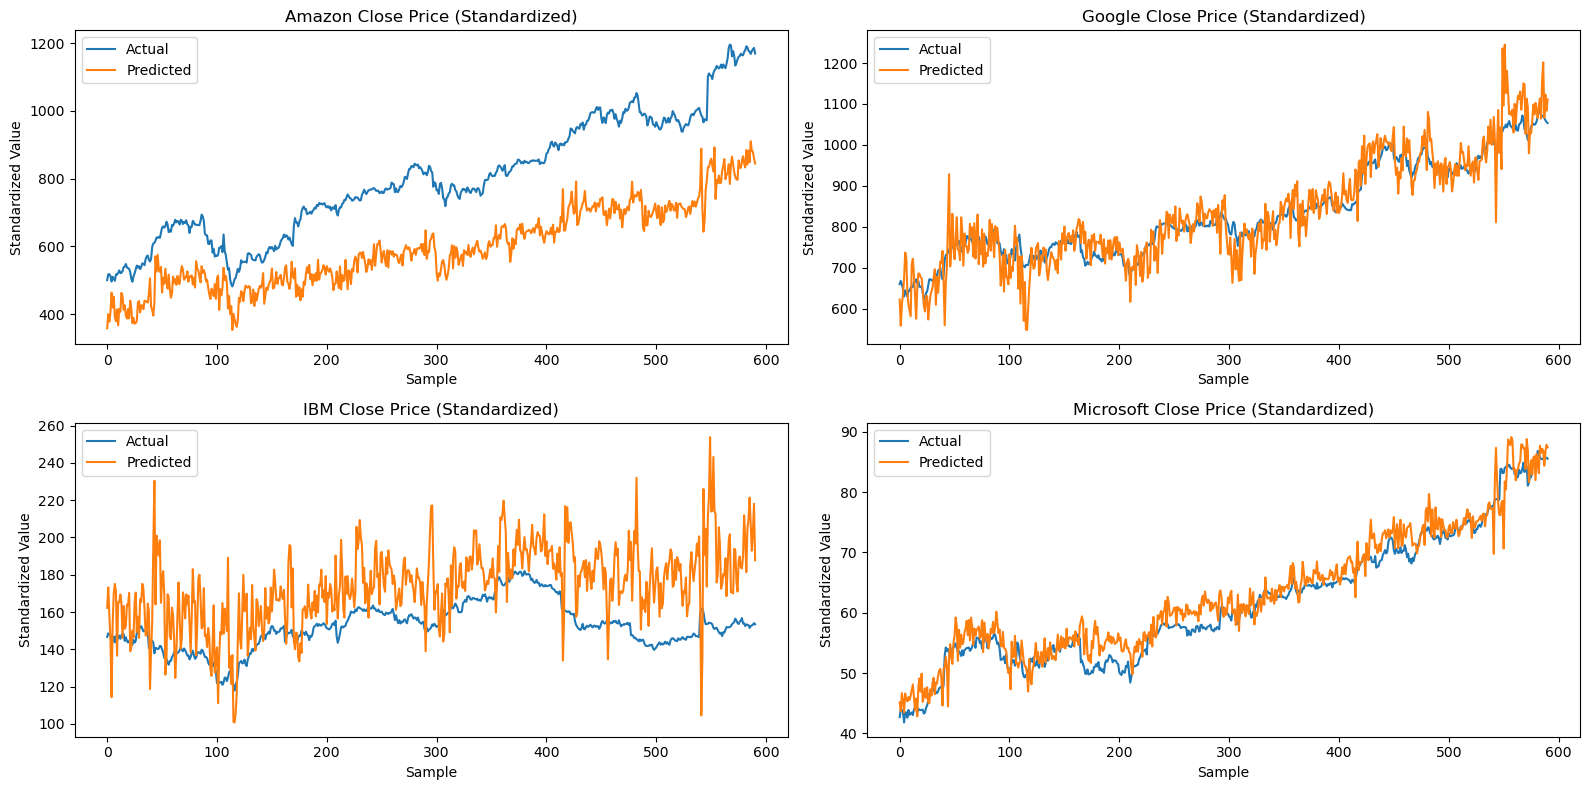

In [2771]:
# Predict on the test data and plot

y_pred = best_model.predict(X_test)

stock_names = ['Amazon', 'Google', 'IBM', 'Microsoft']
y_test_original = y_scaler.inverse_transform(y_test)
y_pred_original = y_scaler.inverse_transform(y_pred)
plt.figure(figsize=(16, 8))
for i, name in enumerate(stock_names):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test_original[:, i], label='Actual')
    plt.plot(y_pred_original[:, i], label='Predicted')
    plt.title(f'{name} Close Price (Standardized)')
    plt.xlabel('Sample')
    plt.ylabel('Standardized Value')
    plt.legend()
plt.tight_layout()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [2772]:
# Compute the performance of the model on the testing data set

num_stocks = y_test.shape[1]

mae_per_stock = []
rmse_per_stock = []
r2_per_stock = []

for i in range(num_stocks):
    y_true_stock = y_test[:, i]
    y_pred_stock = y_pred[:, i]
    
    mae = mean_absolute_error(y_true_stock, y_pred_stock)
    rmse = np.sqrt(mean_squared_error(y_true_stock, y_pred_stock))
    r2 = r2_score(y_true_stock, y_pred_stock)
    
    mae_per_stock.append(mae)
    rmse_per_stock.append(rmse)
    r2_per_stock.append(r2)

print("MAE per stock:", mae_per_stock)
print("RMSE per stock:", rmse_per_stock)
print("R^2 per stock:", r2_per_stock)

print(f"Average MAE: {np.mean(mae_per_stock):.4f}")
print(f"Average RMSE: {np.mean(rmse_per_stock):.4f}")
print(f"Average R^2: {np.mean(r2_per_stock):.4f}")


MAE per stock: [1.7051673823315998, 0.2712910551149016, 0.5807850395041267, 0.30881746985044184]
RMSE per stock: [1.801745171438523, 0.35877113340177974, 0.6964384485097006, 0.3888124084328787]
R^2 per stock: [-0.46011393741260953, 0.8221999801174251, -4.141551919028151, 0.9316170869406792]
Average MAE: 0.7165
Average RMSE: 0.8114
Average R^2: -0.7120


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [2773]:
# # # Define a function to create a model and specify default values for hyperparameters

# def build_model(model_type, units=64, dropout_rate=0.2, lr=0.001, X=None):
#     model = Sequential()
#     if model_type == 'LSTM':
#         model.add(LSTM(units, input_shape=(sequence_length, X.shape[2]), return_sequences=True))
#     elif model_type == 'GRU':
#         #model.add(GRU(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#         GRU(units, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
#         TimeDistributed(Dense(X.shape[2]))
    
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(y_train.shape[1]))

#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
#     return model


In [2774]:
#Define a function to create a model and specify default values for hyperparameters

def build_model(model_type, units=64, dropout_rate=0.2, lr=0.001):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(units, return_sequences=True, activation='relu', input_shape= (X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(32, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units, return_sequences=True, activation='relu', input_shape= (X_train.shape[1], X_train.shape[2])))
        model.add(GRU(32, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1],activation='linear'))

    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


In [2775]:
def train_and_evaluate(model_type, units, dropout, lr,epochs=20,batch_size=32):
    model = build_model(model_type, units, dropout, lr)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [2776]:
# Find an optimal configuration
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=build_model, verbose=2)

param_grid = {
    'model_type':['LSTM','GRU'],
    'units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.0005],
    'epochs': [20, 30],
    'batch_size': [16, 32]
}

search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3)
search_result = search.fit(X_train, y_train)

print("Best parameters:", search_result.best_params_)
print("Best score:", search_result.best_score_)


/var/folders/8z/pbgg5rp57l1gl146pdvm7vhw0000gn/T/ipykernel_78323/1787061669.py:5: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, verbose=2)


Epoch 1/30
50/50 - 3s - loss: 0.2540 - 3s/epoch - 54ms/step
Epoch 2/30
50/50 - 2s - loss: 0.0808 - 2s/epoch - 37ms/step
Epoch 3/30
50/50 - 2s - loss: 0.0652 - 2s/epoch - 34ms/step
Epoch 4/30
50/50 - 2s - loss: 0.0582 - 2s/epoch - 35ms/step
Epoch 5/30
50/50 - 2s - loss: 0.0548 - 2s/epoch - 33ms/step
Epoch 6/30
50/50 - 2s - loss: 0.0521 - 2s/epoch - 34ms/step
Epoch 7/30
50/50 - 2s - loss: 0.0514 - 2s/epoch - 33ms/step
Epoch 8/30
50/50 - 2s - loss: 0.0486 - 2s/epoch - 34ms/step
Epoch 9/30
50/50 - 2s - loss: 0.0482 - 2s/epoch - 35ms/step
Epoch 10/30
50/50 - 2s - loss: 0.0464 - 2s/epoch - 34ms/step
Epoch 11/30
50/50 - 2s - loss: 0.0411 - 2s/epoch - 33ms/step
Epoch 12/30
50/50 - 2s - loss: 0.0453 - 2s/epoch - 34ms/step
Epoch 13/30
50/50 - 2s - loss: 0.0430 - 2s/epoch - 33ms/step
Epoch 14/30
50/50 - 2s - loss: 0.0414 - 2s/epoch - 33ms/step
Epoch 15/30
50/50 - 2s - loss: 0.0402 - 2s/epoch - 34ms/step
Epoch 16/30
50/50 - 2s - loss: 0.0396 - 2s/epoch - 33ms/step
Epoch 17/30
50/50 - 2s - loss: 0.

Epoch 1/30
50/50 - 3s - loss: 0.1920 - 3s/epoch - 50ms/step
Epoch 2/30
50/50 - 2s - loss: 0.0851 - 2s/epoch - 32ms/step
Epoch 3/30
50/50 - 2s - loss: 0.0731 - 2s/epoch - 33ms/step
Epoch 4/30
50/50 - 2s - loss: 0.0684 - 2s/epoch - 34ms/step
Epoch 5/30
50/50 - 2s - loss: 0.0633 - 2s/epoch - 32ms/step
Epoch 6/30
50/50 - 2s - loss: 0.0626 - 2s/epoch - 32ms/step
Epoch 7/30
50/50 - 2s - loss: 0.0576 - 2s/epoch - 34ms/step
Epoch 8/30
50/50 - 2s - loss: 0.0605 - 2s/epoch - 33ms/step
Epoch 9/30
50/50 - 2s - loss: 0.0559 - 2s/epoch - 33ms/step
Epoch 10/30
50/50 - 2s - loss: 0.0555 - 2s/epoch - 33ms/step
Epoch 11/30
50/50 - 2s - loss: 0.0536 - 2s/epoch - 34ms/step
Epoch 12/30
50/50 - 2s - loss: 0.0523 - 2s/epoch - 33ms/step
Epoch 13/30
50/50 - 2s - loss: 0.0524 - 2s/epoch - 34ms/step
Epoch 14/30
50/50 - 2s - loss: 0.0530 - 2s/epoch - 32ms/step
Epoch 15/30
50/50 - 2s - loss: 0.0488 - 2s/epoch - 34ms/step
Epoch 16/30
50/50 - 2s - loss: 0.0507 - 2s/epoch - 32ms/step
Epoch 17/30
50/50 - 2s - loss: 0.

Epoch 1/30
50/50 - 2s - loss: 0.4775 - 2s/epoch - 49ms/step
Epoch 2/30
50/50 - 2s - loss: 0.5049 - 2s/epoch - 33ms/step
Epoch 3/30
50/50 - 2s - loss: 0.3746 - 2s/epoch - 34ms/step
Epoch 4/30
50/50 - 2s - loss: 0.3326 - 2s/epoch - 33ms/step
Epoch 5/30
50/50 - 2s - loss: 0.5297 - 2s/epoch - 33ms/step
Epoch 6/30
50/50 - 2s - loss: 0.3958 - 2s/epoch - 34ms/step
Epoch 7/30
50/50 - 2s - loss: 0.3256 - 2s/epoch - 33ms/step
Epoch 8/30
50/50 - 2s - loss: 0.3010 - 2s/epoch - 34ms/step
Epoch 9/30
50/50 - 2s - loss: 0.2777 - 2s/epoch - 33ms/step
Epoch 10/30
50/50 - 2s - loss: 0.2649 - 2s/epoch - 33ms/step
Epoch 11/30
50/50 - 2s - loss: 0.2611 - 2s/epoch - 34ms/step
Epoch 12/30
50/50 - 2s - loss: 0.2587 - 2s/epoch - 33ms/step
Epoch 13/30
50/50 - 2s - loss: 0.2586 - 2s/epoch - 34ms/step
Epoch 14/30
50/50 - 2s - loss: 0.2445 - 2s/epoch - 34ms/step
Epoch 15/30
50/50 - 2s - loss: 0.3599 - 2s/epoch - 33ms/step
Epoch 16/30
50/50 - 2s - loss: 0.4006 - 2s/epoch - 34ms/step
Epoch 17/30
50/50 - 2s - loss: 0.

Epoch 1/30
99/99 - 3s - loss: 0.1073 - 3s/epoch - 35ms/step
Epoch 2/30
99/99 - 2s - loss: 0.0301 - 2s/epoch - 25ms/step
Epoch 3/30
99/99 - 2s - loss: 0.0250 - 2s/epoch - 25ms/step
Epoch 4/30
99/99 - 3s - loss: 0.0232 - 3s/epoch - 25ms/step
Epoch 5/30
99/99 - 2s - loss: 0.0215 - 2s/epoch - 25ms/step
Epoch 6/30
99/99 - 2s - loss: 0.0194 - 2s/epoch - 25ms/step
Epoch 7/30
99/99 - 3s - loss: 0.0187 - 3s/epoch - 25ms/step
Epoch 8/30
99/99 - 2s - loss: 0.0180 - 2s/epoch - 25ms/step
Epoch 9/30
99/99 - 3s - loss: 0.0171 - 3s/epoch - 25ms/step
Epoch 10/30
99/99 - 3s - loss: 0.0158 - 3s/epoch - 26ms/step
Epoch 11/30
99/99 - 2s - loss: 0.0160 - 2s/epoch - 25ms/step
Epoch 12/30
99/99 - 2s - loss: 0.0134 - 2s/epoch - 25ms/step
Epoch 13/30
99/99 - 3s - loss: 0.0157 - 3s/epoch - 26ms/step
Epoch 14/30
99/99 - 2s - loss: 0.0153 - 2s/epoch - 25ms/step
Epoch 15/30
99/99 - 2s - loss: 0.0153 - 2s/epoch - 25ms/step
Epoch 16/30
99/99 - 3s - loss: 0.0136 - 3s/epoch - 26ms/step
Epoch 17/30
99/99 - 3s - loss: 0.

Epoch 1/30
99/99 - 3s - loss: 0.1066 - 3s/epoch - 34ms/step
Epoch 2/30
99/99 - 3s - loss: 0.0276 - 3s/epoch - 26ms/step
Epoch 3/30
99/99 - 3s - loss: 0.0249 - 3s/epoch - 25ms/step
Epoch 4/30
99/99 - 3s - loss: 0.0233 - 3s/epoch - 25ms/step
Epoch 5/30
99/99 - 3s - loss: 0.0239 - 3s/epoch - 26ms/step
Epoch 6/30
99/99 - 3s - loss: 0.0202 - 3s/epoch - 25ms/step
Epoch 7/30
99/99 - 3s - loss: 0.0194 - 3s/epoch - 25ms/step
Epoch 8/30
99/99 - 3s - loss: 0.0191 - 3s/epoch - 26ms/step
Epoch 9/30
99/99 - 3s - loss: 0.0175 - 3s/epoch - 25ms/step
Epoch 10/30
99/99 - 3s - loss: 0.0189 - 3s/epoch - 25ms/step
Epoch 11/30
99/99 - 3s - loss: 0.0194 - 3s/epoch - 26ms/step
Epoch 12/30
99/99 - 2s - loss: 0.0174 - 2s/epoch - 25ms/step
Epoch 13/30
99/99 - 2s - loss: 0.0173 - 2s/epoch - 25ms/step
Epoch 14/30
99/99 - 3s - loss: 0.0186 - 3s/epoch - 26ms/step
Epoch 15/30
99/99 - 2s - loss: 0.0160 - 2s/epoch - 25ms/step
Epoch 16/30
99/99 - 2s - loss: 0.0175 - 2s/epoch - 25ms/step
Epoch 17/30
99/99 - 3s - loss: 0.

Epoch 1/30
99/99 - 3s - loss: 0.0628 - 3s/epoch - 35ms/step
Epoch 2/30
99/99 - 2s - loss: 0.0168 - 2s/epoch - 25ms/step
Epoch 3/30
99/99 - 2s - loss: 0.0139 - 2s/epoch - 25ms/step
Epoch 4/30
99/99 - 3s - loss: 0.0136 - 3s/epoch - 26ms/step
Epoch 5/30
99/99 - 3s - loss: 0.0121 - 3s/epoch - 28ms/step
Epoch 6/30
99/99 - 3s - loss: 0.0110 - 3s/epoch - 29ms/step
Epoch 7/30
99/99 - 3s - loss: 0.0111 - 3s/epoch - 27ms/step
Epoch 8/30
99/99 - 3s - loss: 0.0104 - 3s/epoch - 28ms/step
Epoch 9/30
99/99 - 3s - loss: 0.0100 - 3s/epoch - 26ms/step
Epoch 10/30
99/99 - 3s - loss: 0.0101 - 3s/epoch - 26ms/step
Epoch 11/30
99/99 - 3s - loss: 0.0100 - 3s/epoch - 26ms/step
Epoch 12/30
99/99 - 3s - loss: 0.0096 - 3s/epoch - 27ms/step
Epoch 13/30
99/99 - 3s - loss: 0.0085 - 3s/epoch - 27ms/step
Epoch 14/30
99/99 - 3s - loss: 0.0087 - 3s/epoch - 28ms/step
Epoch 15/30
99/99 - 3s - loss: 0.0089 - 3s/epoch - 28ms/step
Epoch 16/30
99/99 - 3s - loss: 0.0087 - 3s/epoch - 27ms/step
Epoch 17/30
99/99 - 3s - loss: 0.

Epoch 1/20
99/99 - 2s - loss: 0.1309 - 2s/epoch - 21ms/step
Epoch 2/20
99/99 - 1s - loss: 0.0525 - 1s/epoch - 12ms/step
Epoch 3/20
99/99 - 1s - loss: 0.0384 - 1s/epoch - 13ms/step
Epoch 4/20
99/99 - 1s - loss: 0.0328 - 1s/epoch - 12ms/step
Epoch 5/20
99/99 - 1s - loss: 0.0303 - 1s/epoch - 12ms/step
Epoch 6/20
99/99 - 1s - loss: 0.0262 - 1s/epoch - 13ms/step
Epoch 7/20
99/99 - 1s - loss: 0.0239 - 1s/epoch - 12ms/step
Epoch 8/20
99/99 - 1s - loss: 0.0249 - 1s/epoch - 13ms/step
Epoch 9/20
99/99 - 1s - loss: 0.0220 - 1s/epoch - 13ms/step
Epoch 10/20
99/99 - 1s - loss: 0.0205 - 1s/epoch - 12ms/step
Epoch 11/20
99/99 - 1s - loss: 0.0205 - 1s/epoch - 12ms/step
Epoch 12/20
99/99 - 1s - loss: 0.0193 - 1s/epoch - 13ms/step
Epoch 13/20
99/99 - 1s - loss: 0.0211 - 1s/epoch - 12ms/step
Epoch 14/20
99/99 - 1s - loss: 0.0190 - 1s/epoch - 12ms/step
Epoch 15/20
99/99 - 1s - loss: 0.0189 - 1s/epoch - 13ms/step
Epoch 16/20
99/99 - 1s - loss: 0.0178 - 1s/epoch - 12ms/step
Epoch 17/20
99/99 - 1s - loss: 0.

Epoch 1/20
99/99 - 2s - loss: 0.2532 - 2s/epoch - 22ms/step
Epoch 2/20
99/99 - 1s - loss: 0.0579 - 1s/epoch - 12ms/step
Epoch 3/20
99/99 - 1s - loss: 0.0484 - 1s/epoch - 12ms/step
Epoch 4/20
99/99 - 1s - loss: 0.0386 - 1s/epoch - 13ms/step
Epoch 5/20
99/99 - 1s - loss: 0.0357 - 1s/epoch - 12ms/step
Epoch 6/20
99/99 - 1s - loss: 0.0320 - 1s/epoch - 12ms/step
Epoch 7/20
99/99 - 1s - loss: 0.0310 - 1s/epoch - 13ms/step
Epoch 8/20
99/99 - 1s - loss: 0.0298 - 1s/epoch - 12ms/step
Epoch 9/20
99/99 - 1s - loss: 0.0275 - 1s/epoch - 12ms/step
Epoch 10/20
99/99 - 1s - loss: 0.0272 - 1s/epoch - 13ms/step
Epoch 11/20
99/99 - 1s - loss: 0.0262 - 1s/epoch - 12ms/step
Epoch 12/20
99/99 - 1s - loss: 0.0248 - 1s/epoch - 12ms/step
Epoch 13/20
99/99 - 1s - loss: 0.0230 - 1s/epoch - 13ms/step
Epoch 14/20
99/99 - 1s - loss: 0.0226 - 1s/epoch - 12ms/step
Epoch 15/20
99/99 - 1s - loss: 0.0241 - 1s/epoch - 12ms/step
Epoch 16/20
99/99 - 1s - loss: 0.0211 - 1s/epoch - 13ms/step
Epoch 17/20
99/99 - 1s - loss: 0.

Epoch 1/20
99/99 - 2s - loss: 0.1225 - 2s/epoch - 21ms/step
Epoch 2/20
99/99 - 1s - loss: 0.0264 - 1s/epoch - 13ms/step
Epoch 3/20
99/99 - 1s - loss: 0.0209 - 1s/epoch - 12ms/step
Epoch 4/20
99/99 - 1s - loss: 0.0188 - 1s/epoch - 12ms/step
Epoch 5/20
99/99 - 1s - loss: 0.0167 - 1s/epoch - 13ms/step
Epoch 6/20
99/99 - 1s - loss: 0.0163 - 1s/epoch - 12ms/step
Epoch 7/20
99/99 - 1s - loss: 0.0153 - 1s/epoch - 12ms/step
Epoch 8/20
99/99 - 1s - loss: 0.0143 - 1s/epoch - 13ms/step
Epoch 9/20
99/99 - 1s - loss: 0.0137 - 1s/epoch - 12ms/step
Epoch 10/20
99/99 - 1s - loss: 0.0130 - 1s/epoch - 12ms/step
Epoch 11/20
99/99 - 1s - loss: 0.0125 - 1s/epoch - 13ms/step
Epoch 12/20
99/99 - 1s - loss: 0.0121 - 1s/epoch - 12ms/step
Epoch 13/20
99/99 - 1s - loss: 0.0113 - 1s/epoch - 12ms/step
Epoch 14/20
99/99 - 1s - loss: 0.0114 - 1s/epoch - 13ms/step
Epoch 15/20
99/99 - 1s - loss: 0.0110 - 1s/epoch - 12ms/step
Epoch 16/20
99/99 - 1s - loss: 0.0106 - 1s/epoch - 13ms/step
Epoch 17/20
99/99 - 2s - loss: 0.

Epoch 1/30
99/99 - 3s - loss: 0.2276 - 3s/epoch - 35ms/step
Epoch 2/30
99/99 - 3s - loss: 0.0705 - 3s/epoch - 28ms/step
Epoch 3/30
99/99 - 3s - loss: 0.0661 - 3s/epoch - 26ms/step
Epoch 4/30
99/99 - 3s - loss: 0.0539 - 3s/epoch - 27ms/step
Epoch 5/30
99/99 - 3s - loss: 0.0546 - 3s/epoch - 26ms/step
Epoch 6/30
99/99 - 3s - loss: 0.0545 - 3s/epoch - 27ms/step
Epoch 7/30
99/99 - 3s - loss: 0.0470 - 3s/epoch - 28ms/step
Epoch 8/30
99/99 - 3s - loss: 0.0488 - 3s/epoch - 28ms/step
Epoch 9/30
99/99 - 3s - loss: 0.0469 - 3s/epoch - 26ms/step
Epoch 10/30
99/99 - 3s - loss: 0.0441 - 3s/epoch - 26ms/step
Epoch 11/30
99/99 - 3s - loss: 0.0418 - 3s/epoch - 28ms/step
Epoch 12/30
99/99 - 3s - loss: 0.0457 - 3s/epoch - 26ms/step
Epoch 13/30
99/99 - 3s - loss: 0.0417 - 3s/epoch - 27ms/step
Epoch 14/30
99/99 - 3s - loss: 0.0395 - 3s/epoch - 26ms/step
Epoch 15/30
99/99 - 3s - loss: 0.0397 - 3s/epoch - 27ms/step
Epoch 16/30
99/99 - 3s - loss: 0.0383 - 3s/epoch - 26ms/step
Epoch 17/30
99/99 - 3s - loss: 0.

Epoch 1/30
99/99 - 3s - loss: 0.2733 - 3s/epoch - 35ms/step
Epoch 2/30
99/99 - 3s - loss: 0.0992 - 3s/epoch - 26ms/step
Epoch 3/30
99/99 - 3s - loss: 0.0862 - 3s/epoch - 26ms/step
Epoch 4/30
99/99 - 3s - loss: 0.0794 - 3s/epoch - 26ms/step
Epoch 5/30
99/99 - 3s - loss: 0.0735 - 3s/epoch - 26ms/step
Epoch 6/30
99/99 - 3s - loss: 0.0668 - 3s/epoch - 26ms/step
Epoch 7/30
99/99 - 3s - loss: 0.0643 - 3s/epoch - 25ms/step
Epoch 8/30
99/99 - 3s - loss: 0.0603 - 3s/epoch - 26ms/step
Epoch 9/30
99/99 - 3s - loss: 0.0609 - 3s/epoch - 25ms/step
Epoch 10/30
99/99 - 3s - loss: 0.0591 - 3s/epoch - 25ms/step
Epoch 11/30
99/99 - 3s - loss: 0.0564 - 3s/epoch - 26ms/step
Epoch 12/30
99/99 - 3s - loss: 0.0520 - 3s/epoch - 26ms/step
Epoch 13/30
99/99 - 3s - loss: 0.0536 - 3s/epoch - 25ms/step
Epoch 14/30
99/99 - 3s - loss: 0.0512 - 3s/epoch - 26ms/step
Epoch 15/30
99/99 - 3s - loss: 0.0520 - 3s/epoch - 25ms/step
Epoch 16/30
99/99 - 3s - loss: 0.0473 - 3s/epoch - 25ms/step
Epoch 17/30
99/99 - 3s - loss: 0.

Epoch 1/30
99/99 - 3s - loss: 0.1133 - 3s/epoch - 35ms/step
Epoch 2/30
99/99 - 3s - loss: 0.0449 - 3s/epoch - 26ms/step
Epoch 3/30
99/99 - 3s - loss: 0.0397 - 3s/epoch - 26ms/step
Epoch 4/30
99/99 - 3s - loss: 0.0345 - 3s/epoch - 26ms/step
Epoch 5/30
99/99 - 3s - loss: 0.0329 - 3s/epoch - 27ms/step
Epoch 6/30
99/99 - 3s - loss: 0.0329 - 3s/epoch - 27ms/step
Epoch 7/30
99/99 - 3s - loss: 0.0295 - 3s/epoch - 26ms/step
Epoch 8/30
99/99 - 3s - loss: 0.0270 - 3s/epoch - 25ms/step
Epoch 9/30
99/99 - 3s - loss: 0.0267 - 3s/epoch - 26ms/step
Epoch 10/30
99/99 - 3s - loss: 0.0252 - 3s/epoch - 26ms/step
Epoch 11/30
99/99 - 3s - loss: 0.0236 - 3s/epoch - 26ms/step
Epoch 12/30
99/99 - 3s - loss: 0.0229 - 3s/epoch - 29ms/step
Epoch 13/30
99/99 - 3s - loss: 0.0228 - 3s/epoch - 29ms/step
Epoch 14/30
99/99 - 3s - loss: 0.0219 - 3s/epoch - 29ms/step
Epoch 15/30
99/99 - 3s - loss: 0.0220 - 3s/epoch - 29ms/step
Epoch 16/30
99/99 - 3s - loss: 0.0214 - 3s/epoch - 28ms/step
Epoch 17/30
99/99 - 3s - loss: 0.

Epoch 1/30
50/50 - 2s - loss: 0.2013 - 2s/epoch - 38ms/step
Epoch 2/30
50/50 - 1s - loss: 0.0540 - 919ms/epoch - 18ms/step
Epoch 3/30
50/50 - 1s - loss: 0.0345 - 914ms/epoch - 18ms/step
Epoch 4/30
50/50 - 1s - loss: 0.0298 - 920ms/epoch - 18ms/step
Epoch 5/30
50/50 - 1s - loss: 0.0262 - 924ms/epoch - 18ms/step
Epoch 6/30
50/50 - 1s - loss: 0.0243 - 942ms/epoch - 19ms/step
Epoch 7/30
50/50 - 1s - loss: 0.0230 - 954ms/epoch - 19ms/step
Epoch 8/30
50/50 - 1s - loss: 0.0221 - 968ms/epoch - 19ms/step
Epoch 9/30
50/50 - 1s - loss: 0.0211 - 930ms/epoch - 19ms/step
Epoch 10/30
50/50 - 1s - loss: 0.0206 - 1s/epoch - 21ms/step
Epoch 11/30
50/50 - 1s - loss: 0.0194 - 939ms/epoch - 19ms/step
Epoch 12/30
50/50 - 1s - loss: 0.0184 - 935ms/epoch - 19ms/step
Epoch 13/30
50/50 - 1s - loss: 0.0183 - 994ms/epoch - 20ms/step
Epoch 14/30
50/50 - 1s - loss: 0.0165 - 922ms/epoch - 18ms/step
Epoch 15/30
50/50 - 1s - loss: 0.0165 - 920ms/epoch - 18ms/step
Epoch 16/30
50/50 - 1s - loss: 0.0167 - 924ms/epoch - 1

Epoch 1/30
50/50 - 2s - loss: 0.4093 - 2s/epoch - 38ms/step
Epoch 2/30
50/50 - 1s - loss: 0.0628 - 951ms/epoch - 19ms/step
Epoch 3/30
50/50 - 1s - loss: 0.0422 - 934ms/epoch - 19ms/step
Epoch 4/30
50/50 - 1s - loss: 0.0355 - 938ms/epoch - 19ms/step
Epoch 5/30
50/50 - 1s - loss: 0.0316 - 948ms/epoch - 19ms/step
Epoch 6/30
50/50 - 1s - loss: 0.0300 - 947ms/epoch - 19ms/step
Epoch 7/30
50/50 - 1s - loss: 0.0279 - 964ms/epoch - 19ms/step
Epoch 8/30
50/50 - 1s - loss: 0.0261 - 944ms/epoch - 19ms/step
Epoch 9/30
50/50 - 1s - loss: 0.0247 - 938ms/epoch - 19ms/step
Epoch 10/30
50/50 - 1s - loss: 0.0248 - 932ms/epoch - 19ms/step
Epoch 11/30
50/50 - 1s - loss: 0.0251 - 933ms/epoch - 19ms/step
Epoch 12/30
50/50 - 1s - loss: 0.0226 - 937ms/epoch - 19ms/step
Epoch 13/30
50/50 - 1s - loss: 0.0235 - 935ms/epoch - 19ms/step
Epoch 14/30
50/50 - 1s - loss: 0.0220 - 931ms/epoch - 19ms/step
Epoch 15/30
50/50 - 1s - loss: 0.0225 - 954ms/epoch - 19ms/step
Epoch 16/30
50/50 - 1s - loss: 0.0224 - 979ms/epoch 

Epoch 1/30
50/50 - 2s - loss: 0.2145 - 2s/epoch - 40ms/step
Epoch 2/30
50/50 - 1s - loss: 0.0295 - 967ms/epoch - 19ms/step
Epoch 3/30
50/50 - 1s - loss: 0.0206 - 1s/epoch - 22ms/step
Epoch 4/30
50/50 - 1s - loss: 0.0186 - 981ms/epoch - 20ms/step
Epoch 5/30
50/50 - 1s - loss: 0.0175 - 956ms/epoch - 19ms/step
Epoch 6/30
50/50 - 1s - loss: 0.0153 - 956ms/epoch - 19ms/step
Epoch 7/30
50/50 - 1s - loss: 0.0151 - 952ms/epoch - 19ms/step
Epoch 8/30
50/50 - 1s - loss: 0.0143 - 966ms/epoch - 19ms/step
Epoch 9/30
50/50 - 1s - loss: 0.0137 - 952ms/epoch - 19ms/step
Epoch 10/30
50/50 - 1s - loss: 0.0132 - 958ms/epoch - 19ms/step
Epoch 11/30
50/50 - 1s - loss: 0.0132 - 1s/epoch - 21ms/step
Epoch 12/30
50/50 - 1s - loss: 0.0122 - 1s/epoch - 20ms/step
Epoch 13/30
50/50 - 1s - loss: 0.0127 - 1s/epoch - 20ms/step
Epoch 14/30
50/50 - 1s - loss: 0.0124 - 1s/epoch - 21ms/step
Epoch 15/30
50/50 - 1s - loss: 0.0115 - 1s/epoch - 22ms/step
Epoch 16/30
50/50 - 1s - loss: 0.0111 - 1s/epoch - 21ms/step
Epoch 17/

Epoch 1/20
50/50 - 2s - loss: 0.2395 - 2s/epoch - 38ms/step
Epoch 2/20
50/50 - 1s - loss: 0.0768 - 1s/epoch - 22ms/step
Epoch 3/20
50/50 - 1s - loss: 0.0643 - 938ms/epoch - 19ms/step
Epoch 4/20
50/50 - 1s - loss: 0.0554 - 934ms/epoch - 19ms/step
Epoch 5/20
50/50 - 1s - loss: 0.0509 - 949ms/epoch - 19ms/step
Epoch 6/20
50/50 - 1s - loss: 0.0460 - 938ms/epoch - 19ms/step
Epoch 7/20
50/50 - 1s - loss: 0.0460 - 954ms/epoch - 19ms/step
Epoch 8/20
50/50 - 1s - loss: 0.0432 - 932ms/epoch - 19ms/step
Epoch 9/20
50/50 - 1s - loss: 0.0439 - 940ms/epoch - 19ms/step
Epoch 10/20
50/50 - 1s - loss: 0.0403 - 964ms/epoch - 19ms/step
Epoch 11/20
50/50 - 1s - loss: 0.0371 - 944ms/epoch - 19ms/step
Epoch 12/20
50/50 - 1s - loss: 0.0381 - 931ms/epoch - 19ms/step
Epoch 13/20
50/50 - 1s - loss: 0.0380 - 949ms/epoch - 19ms/step
Epoch 14/20
50/50 - 1s - loss: 0.0371 - 948ms/epoch - 19ms/step
Epoch 15/20
50/50 - 1s - loss: 0.0348 - 971ms/epoch - 19ms/step
Epoch 16/20
50/50 - 1s - loss: 0.0352 - 941ms/epoch - 1

Epoch 1/20
50/50 - 2s - loss: 0.3912 - 2s/epoch - 36ms/step
Epoch 2/20
50/50 - 1s - loss: 0.0987 - 918ms/epoch - 18ms/step
Epoch 3/20
50/50 - 1s - loss: 0.0801 - 926ms/epoch - 19ms/step
Epoch 4/20
50/50 - 1s - loss: 0.0722 - 917ms/epoch - 18ms/step
Epoch 5/20
50/50 - 1s - loss: 0.0714 - 921ms/epoch - 18ms/step
Epoch 6/20
50/50 - 1s - loss: 0.0603 - 937ms/epoch - 19ms/step
Epoch 7/20
50/50 - 1s - loss: 0.0598 - 927ms/epoch - 19ms/step
Epoch 8/20
50/50 - 1s - loss: 0.0559 - 930ms/epoch - 19ms/step
Epoch 9/20
50/50 - 1s - loss: 0.0543 - 928ms/epoch - 19ms/step
Epoch 10/20
50/50 - 1s - loss: 0.0528 - 959ms/epoch - 19ms/step
Epoch 11/20
50/50 - 1s - loss: 0.0523 - 930ms/epoch - 19ms/step
Epoch 12/20
50/50 - 1s - loss: 0.0451 - 937ms/epoch - 19ms/step
Epoch 13/20
50/50 - 1s - loss: 0.0490 - 918ms/epoch - 18ms/step
Epoch 14/20
50/50 - 1s - loss: 0.0446 - 966ms/epoch - 19ms/step
Epoch 15/20
50/50 - 1s - loss: 0.0439 - 920ms/epoch - 18ms/step
Epoch 16/20
50/50 - 1s - loss: 0.0442 - 917ms/epoch 

Epoch 1/20
50/50 - 2s - loss: 0.1676 - 2s/epoch - 37ms/step
Epoch 2/20
50/50 - 1s - loss: 0.0442 - 933ms/epoch - 19ms/step
Epoch 3/20
50/50 - 1s - loss: 0.0392 - 922ms/epoch - 18ms/step
Epoch 4/20
50/50 - 1s - loss: 0.0357 - 942ms/epoch - 19ms/step
Epoch 5/20
50/50 - 1s - loss: 0.0297 - 918ms/epoch - 18ms/step
Epoch 6/20
50/50 - 1s - loss: 0.0293 - 915ms/epoch - 18ms/step
Epoch 7/20
50/50 - 1s - loss: 0.0273 - 916ms/epoch - 18ms/step
Epoch 8/20
50/50 - 1s - loss: 0.0251 - 935ms/epoch - 19ms/step
Epoch 9/20
50/50 - 1s - loss: 0.0239 - 924ms/epoch - 18ms/step
Epoch 10/20
50/50 - 1s - loss: 0.0244 - 975ms/epoch - 20ms/step
Epoch 11/20
50/50 - 1s - loss: 0.0230 - 933ms/epoch - 19ms/step
Epoch 12/20
50/50 - 1s - loss: 0.0237 - 928ms/epoch - 19ms/step
Epoch 13/20
50/50 - 1s - loss: 0.0222 - 943ms/epoch - 19ms/step
Epoch 14/20
50/50 - 1s - loss: 0.0203 - 919ms/epoch - 18ms/step
Epoch 15/20
50/50 - 1s - loss: 0.0211 - 927ms/epoch - 19ms/step
Epoch 16/20
50/50 - 1s - loss: 0.0197 - 927ms/epoch 

Epoch 1/30
50/50 - 2s - loss: 0.3847 - 2s/epoch - 37ms/step
Epoch 2/30
50/50 - 1s - loss: 0.2151 - 933ms/epoch - 19ms/step
Epoch 3/30
50/50 - 1s - loss: 0.1342 - 935ms/epoch - 19ms/step
Epoch 4/30
50/50 - 1s - loss: 0.1665 - 919ms/epoch - 18ms/step
Epoch 5/30
50/50 - 1s - loss: 0.0739 - 942ms/epoch - 19ms/step
Epoch 6/30
50/50 - 1s - loss: 0.0637 - 959ms/epoch - 19ms/step
Epoch 7/30
50/50 - 1s - loss: 0.0558 - 927ms/epoch - 19ms/step
Epoch 8/30
50/50 - 1s - loss: 0.0468 - 936ms/epoch - 19ms/step
Epoch 9/30
50/50 - 1s - loss: 0.0390 - 920ms/epoch - 18ms/step
Epoch 10/30
50/50 - 1s - loss: 0.0357 - 924ms/epoch - 18ms/step
Epoch 11/30
50/50 - 1s - loss: 0.0395 - 924ms/epoch - 18ms/step
Epoch 12/30
50/50 - 1s - loss: 0.0334 - 922ms/epoch - 18ms/step
Epoch 13/30
50/50 - 1s - loss: 0.0320 - 937ms/epoch - 19ms/step
Epoch 14/30
50/50 - 1s - loss: 0.0320 - 923ms/epoch - 18ms/step
Epoch 15/30
50/50 - 1s - loss: 0.0292 - 925ms/epoch - 18ms/step
Epoch 16/30
50/50 - 1s - loss: 0.0301 - 923ms/epoch 

Epoch 1/30
50/50 - 2s - loss: 0.2891 - 2s/epoch - 37ms/step
Epoch 2/30
50/50 - 1s - loss: 0.0598 - 938ms/epoch - 19ms/step
Epoch 3/30
50/50 - 1s - loss: 0.0465 - 948ms/epoch - 19ms/step
Epoch 4/30
50/50 - 1s - loss: 0.0392 - 946ms/epoch - 19ms/step
Epoch 5/30
50/50 - 1s - loss: 0.0377 - 928ms/epoch - 19ms/step
Epoch 6/30
50/50 - 1s - loss: 0.0329 - 931ms/epoch - 19ms/step
Epoch 7/30
50/50 - 1s - loss: 0.0312 - 922ms/epoch - 18ms/step
Epoch 8/30
50/50 - 1s - loss: 0.0286 - 949ms/epoch - 19ms/step
Epoch 9/30
50/50 - 1s - loss: 0.0277 - 951ms/epoch - 19ms/step
Epoch 10/30
50/50 - 1s - loss: 0.0259 - 932ms/epoch - 19ms/step
Epoch 11/30
50/50 - 1s - loss: 0.0229 - 925ms/epoch - 19ms/step
Epoch 12/30
50/50 - 1s - loss: 0.0239 - 934ms/epoch - 19ms/step
Epoch 13/30
50/50 - 1s - loss: 0.0226 - 935ms/epoch - 19ms/step
Epoch 14/30
50/50 - 1s - loss: 0.0218 - 931ms/epoch - 19ms/step
Epoch 15/30
50/50 - 1s - loss: 0.0209 - 930ms/epoch - 19ms/step
Epoch 16/30
50/50 - 1s - loss: 0.0228 - 939ms/epoch 

Epoch 1/30
50/50 - 2s - loss: 0.1266 - 2s/epoch - 36ms/step
Epoch 2/30
50/50 - 1s - loss: 0.0299 - 929ms/epoch - 19ms/step
Epoch 3/30
50/50 - 1s - loss: 0.0238 - 922ms/epoch - 18ms/step
Epoch 4/30
50/50 - 1s - loss: 0.0192 - 929ms/epoch - 19ms/step
Epoch 5/30
50/50 - 1s - loss: 0.0182 - 936ms/epoch - 19ms/step
Epoch 6/30
50/50 - 1s - loss: 0.0159 - 925ms/epoch - 18ms/step
Epoch 7/30
50/50 - 1s - loss: 0.0157 - 927ms/epoch - 19ms/step
Epoch 8/30
50/50 - 1s - loss: 0.0152 - 925ms/epoch - 18ms/step
Epoch 9/30
50/50 - 1s - loss: 0.0147 - 931ms/epoch - 19ms/step
Epoch 10/30
50/50 - 1s - loss: 0.0138 - 935ms/epoch - 19ms/step
Epoch 11/30
50/50 - 1s - loss: 0.0132 - 984ms/epoch - 20ms/step
Epoch 12/30
50/50 - 1s - loss: 0.0131 - 933ms/epoch - 19ms/step
Epoch 13/30
50/50 - 1s - loss: 0.0126 - 928ms/epoch - 19ms/step
Epoch 14/30
50/50 - 1s - loss: 0.0115 - 929ms/epoch - 19ms/step
Epoch 15/30
50/50 - 1s - loss: 0.0115 - 930ms/epoch - 19ms/step
Epoch 16/30
50/50 - 1s - loss: 0.0115 - 921ms/epoch 

Epoch 1/20
99/99 - 2s - loss: 0.2865 - 2s/epoch - 22ms/step
Epoch 2/20
99/99 - 1s - loss: 0.0655 - 1s/epoch - 13ms/step
Epoch 3/20
99/99 - 1s - loss: 0.0507 - 1s/epoch - 14ms/step
Epoch 4/20
99/99 - 1s - loss: 0.0466 - 1s/epoch - 12ms/step
Epoch 5/20
99/99 - 1s - loss: 0.0378 - 1s/epoch - 13ms/step
Epoch 6/20
99/99 - 1s - loss: 0.0360 - 1s/epoch - 13ms/step
Epoch 7/20
99/99 - 1s - loss: 0.0335 - 1s/epoch - 13ms/step
Epoch 8/20
99/99 - 1s - loss: 0.0315 - 1s/epoch - 13ms/step
Epoch 9/20
99/99 - 1s - loss: 0.0327 - 1s/epoch - 12ms/step
Epoch 10/20
99/99 - 1s - loss: 0.0287 - 1s/epoch - 15ms/step
Epoch 11/20
99/99 - 2s - loss: 0.0281 - 2s/epoch - 15ms/step
Epoch 12/20
99/99 - 1s - loss: 0.0276 - 1s/epoch - 15ms/step
Epoch 13/20
99/99 - 1s - loss: 0.0255 - 1s/epoch - 15ms/step
Epoch 14/20
99/99 - 1s - loss: 0.0232 - 1s/epoch - 15ms/step
Epoch 15/20
99/99 - 1s - loss: 0.0252 - 1s/epoch - 14ms/step
Epoch 16/20
99/99 - 2s - loss: 0.0225 - 2s/epoch - 15ms/step
Epoch 17/20
99/99 - 1s - loss: 0.

Epoch 1/20
99/99 - 2s - loss: 0.2245 - 2s/epoch - 24ms/step
Epoch 2/20
99/99 - 1s - loss: 0.0626 - 1s/epoch - 12ms/step
Epoch 3/20
99/99 - 1s - loss: 0.0535 - 1s/epoch - 13ms/step
Epoch 4/20
99/99 - 1s - loss: 0.0459 - 1s/epoch - 12ms/step
Epoch 5/20
99/99 - 1s - loss: 0.0421 - 1s/epoch - 13ms/step
Epoch 6/20
99/99 - 1s - loss: 0.0389 - 1s/epoch - 12ms/step
Epoch 7/20
99/99 - 1s - loss: 0.0371 - 1s/epoch - 14ms/step
Epoch 8/20
99/99 - 1s - loss: 0.0359 - 1s/epoch - 13ms/step
Epoch 9/20
99/99 - 1s - loss: 0.0334 - 1s/epoch - 13ms/step
Epoch 10/20
99/99 - 1s - loss: 0.0307 - 1s/epoch - 12ms/step
Epoch 11/20
99/99 - 1s - loss: 0.0323 - 1s/epoch - 13ms/step
Epoch 12/20
99/99 - 1s - loss: 0.0284 - 1s/epoch - 13ms/step
Epoch 13/20
99/99 - 1s - loss: 0.0272 - 1s/epoch - 14ms/step
Epoch 14/20
99/99 - 1s - loss: 0.0265 - 1s/epoch - 13ms/step
Epoch 15/20
99/99 - 1s - loss: 0.0253 - 1s/epoch - 13ms/step
Epoch 16/20
99/99 - 1s - loss: 0.0261 - 1s/epoch - 13ms/step
Epoch 17/20
99/99 - 1s - loss: 0.

Epoch 1/20
99/99 - 2s - loss: 0.2556 - 2s/epoch - 22ms/step
Epoch 2/20
99/99 - 1s - loss: 0.0388 - 1s/epoch - 13ms/step
Epoch 3/20
99/99 - 1s - loss: 0.0290 - 1s/epoch - 13ms/step
Epoch 4/20
99/99 - 1s - loss: 0.0258 - 1s/epoch - 14ms/step
Epoch 5/20
99/99 - 1s - loss: 0.0220 - 1s/epoch - 13ms/step
Epoch 6/20
99/99 - 1s - loss: 0.0204 - 1s/epoch - 13ms/step
Epoch 7/20
99/99 - 1s - loss: 0.0186 - 1s/epoch - 13ms/step
Epoch 8/20
99/99 - 1s - loss: 0.0177 - 1s/epoch - 13ms/step
Epoch 9/20
99/99 - 1s - loss: 0.0159 - 1s/epoch - 13ms/step
Epoch 10/20
99/99 - 1s - loss: 0.0159 - 1s/epoch - 13ms/step
Epoch 11/20
99/99 - 1s - loss: 0.0160 - 1s/epoch - 13ms/step
Epoch 12/20
99/99 - 1s - loss: 0.0144 - 1s/epoch - 13ms/step
Epoch 13/20
99/99 - 1s - loss: 0.0139 - 1s/epoch - 13ms/step
Epoch 14/20
99/99 - 1s - loss: 0.0145 - 1s/epoch - 13ms/step
Epoch 15/20
99/99 - 1s - loss: 0.0134 - 1s/epoch - 14ms/step
Epoch 16/20
99/99 - 1s - loss: 0.0132 - 1s/epoch - 14ms/step
Epoch 17/20
99/99 - 1s - loss: 0.

Epoch 1/30
50/50 - 3s - loss: 0.2436 - 3s/epoch - 51ms/step
Epoch 2/30
50/50 - 2s - loss: 0.0836 - 2s/epoch - 32ms/step
Epoch 3/30
50/50 - 2s - loss: 0.0729 - 2s/epoch - 34ms/step
Epoch 4/30
50/50 - 2s - loss: 0.0609 - 2s/epoch - 32ms/step
Epoch 5/30
50/50 - 2s - loss: 0.0581 - 2s/epoch - 32ms/step
Epoch 6/30
50/50 - 2s - loss: 0.0517 - 2s/epoch - 33ms/step
Epoch 7/30
50/50 - 2s - loss: 0.0512 - 2s/epoch - 32ms/step
Epoch 8/30
50/50 - 2s - loss: 0.0460 - 2s/epoch - 33ms/step
Epoch 9/30
50/50 - 2s - loss: 0.0460 - 2s/epoch - 33ms/step
Epoch 10/30
50/50 - 2s - loss: 0.0435 - 2s/epoch - 32ms/step
Epoch 11/30
50/50 - 2s - loss: 0.0448 - 2s/epoch - 32ms/step
Epoch 12/30
50/50 - 2s - loss: 0.0383 - 2s/epoch - 33ms/step
Epoch 13/30
50/50 - 2s - loss: 0.0402 - 2s/epoch - 32ms/step
Epoch 14/30
50/50 - 2s - loss: 0.0390 - 2s/epoch - 32ms/step
Epoch 15/30
50/50 - 2s - loss: 0.0381 - 2s/epoch - 33ms/step
Epoch 16/30
50/50 - 2s - loss: 0.0359 - 2s/epoch - 33ms/step
Epoch 17/30
50/50 - 2s - loss: 0.

Epoch 1/30
50/50 - 3s - loss: 0.2454 - 3s/epoch - 53ms/step
Epoch 2/30
50/50 - 2s - loss: 0.0930 - 2s/epoch - 34ms/step
Epoch 3/30
50/50 - 2s - loss: 0.0743 - 2s/epoch - 35ms/step
Epoch 4/30
50/50 - 2s - loss: 0.0699 - 2s/epoch - 36ms/step
Epoch 5/30
50/50 - 2s - loss: 0.0654 - 2s/epoch - 33ms/step
Epoch 6/30
50/50 - 2s - loss: 0.0603 - 2s/epoch - 34ms/step
Epoch 7/30
50/50 - 2s - loss: 0.0616 - 2s/epoch - 33ms/step
Epoch 8/30
50/50 - 2s - loss: 0.0573 - 2s/epoch - 33ms/step
Epoch 9/30
50/50 - 2s - loss: 0.0519 - 2s/epoch - 32ms/step
Epoch 10/30
50/50 - 2s - loss: 0.0582 - 2s/epoch - 32ms/step
Epoch 11/30
50/50 - 2s - loss: 0.0531 - 2s/epoch - 34ms/step
Epoch 12/30
50/50 - 2s - loss: 0.0518 - 2s/epoch - 34ms/step
Epoch 13/30
50/50 - 2s - loss: 0.0502 - 2s/epoch - 36ms/step
Epoch 14/30
50/50 - 2s - loss: 0.0507 - 2s/epoch - 34ms/step
Epoch 15/30
50/50 - 2s - loss: 0.0502 - 2s/epoch - 34ms/step
Epoch 16/30
50/50 - 2s - loss: 0.0489 - 2s/epoch - 33ms/step
Epoch 17/30
50/50 - 2s - loss: 0.

Epoch 1/30
50/50 - 3s - loss: 0.1345 - 3s/epoch - 52ms/step
Epoch 2/30
50/50 - 2s - loss: 0.0452 - 2s/epoch - 31ms/step
Epoch 3/30
50/50 - 2s - loss: 0.0384 - 2s/epoch - 31ms/step
Epoch 4/30
50/50 - 2s - loss: 0.0344 - 2s/epoch - 32ms/step
Epoch 5/30
50/50 - 2s - loss: 0.0321 - 2s/epoch - 31ms/step
Epoch 6/30
50/50 - 2s - loss: 0.0295 - 2s/epoch - 31ms/step
Epoch 7/30
50/50 - 2s - loss: 0.0288 - 2s/epoch - 32ms/step
Epoch 8/30
50/50 - 2s - loss: 0.0261 - 2s/epoch - 31ms/step
Epoch 9/30
50/50 - 2s - loss: 0.0247 - 2s/epoch - 31ms/step
Epoch 10/30
50/50 - 2s - loss: 0.0247 - 2s/epoch - 32ms/step
Epoch 11/30
50/50 - 2s - loss: 0.0242 - 2s/epoch - 30ms/step
Epoch 12/30
50/50 - 2s - loss: 0.0237 - 2s/epoch - 31ms/step
Epoch 13/30
50/50 - 2s - loss: 0.0237 - 2s/epoch - 32ms/step
Epoch 14/30
50/50 - 2s - loss: 0.0223 - 2s/epoch - 31ms/step
Epoch 15/30
50/50 - 2s - loss: 0.0214 - 2s/epoch - 31ms/step
Epoch 16/30
50/50 - 2s - loss: 0.0210 - 2s/epoch - 30ms/step
Epoch 17/30
50/50 - 2s - loss: 0.

Epoch 1/30
99/99 - 2s - loss: 0.1471 - 2s/epoch - 21ms/step
Epoch 2/30
99/99 - 1s - loss: 0.0432 - 1s/epoch - 13ms/step
Epoch 3/30
99/99 - 1s - loss: 0.0352 - 1s/epoch - 12ms/step
Epoch 4/30
99/99 - 1s - loss: 0.0316 - 1s/epoch - 12ms/step
Epoch 5/30
99/99 - 1s - loss: 0.0277 - 1s/epoch - 12ms/step
Epoch 6/30
99/99 - 1s - loss: 0.0266 - 1s/epoch - 12ms/step
Epoch 7/30
99/99 - 1s - loss: 0.0247 - 1s/epoch - 12ms/step
Epoch 8/30
99/99 - 1s - loss: 0.0226 - 1s/epoch - 12ms/step
Epoch 9/30
99/99 - 1s - loss: 0.0232 - 1s/epoch - 12ms/step
Epoch 10/30
99/99 - 1s - loss: 0.0207 - 1s/epoch - 12ms/step
Epoch 11/30
99/99 - 1s - loss: 0.0206 - 1s/epoch - 12ms/step
Epoch 12/30
99/99 - 1s - loss: 0.0190 - 1s/epoch - 13ms/step
Epoch 13/30
99/99 - 1s - loss: 0.0174 - 1s/epoch - 12ms/step
Epoch 14/30
99/99 - 1s - loss: 0.0175 - 1s/epoch - 12ms/step
Epoch 15/30
99/99 - 1s - loss: 0.0189 - 1s/epoch - 12ms/step
Epoch 16/30
99/99 - 1s - loss: 0.0179 - 1s/epoch - 12ms/step
Epoch 17/30
99/99 - 1s - loss: 0.

Epoch 1/30
99/99 - 2s - loss: 0.2272 - 2s/epoch - 23ms/step
Epoch 2/30
99/99 - 1s - loss: 0.0532 - 1s/epoch - 14ms/step
Epoch 3/30
99/99 - 1s - loss: 0.0405 - 1s/epoch - 13ms/step
Epoch 4/30
99/99 - 1s - loss: 0.0353 - 1s/epoch - 13ms/step
Epoch 5/30
99/99 - 1s - loss: 0.0336 - 1s/epoch - 14ms/step
Epoch 6/30
99/99 - 1s - loss: 0.0296 - 1s/epoch - 13ms/step
Epoch 7/30
99/99 - 1s - loss: 0.0290 - 1s/epoch - 13ms/step
Epoch 8/30
99/99 - 1s - loss: 0.0263 - 1s/epoch - 14ms/step
Epoch 9/30
99/99 - 1s - loss: 0.0264 - 1s/epoch - 14ms/step
Epoch 10/30
99/99 - 1s - loss: 0.0250 - 1s/epoch - 14ms/step
Epoch 11/30
99/99 - 1s - loss: 0.0250 - 1s/epoch - 13ms/step
Epoch 12/30
99/99 - 1s - loss: 0.0231 - 1s/epoch - 14ms/step
Epoch 13/30
99/99 - 1s - loss: 0.0222 - 1s/epoch - 14ms/step
Epoch 14/30
99/99 - 1s - loss: 0.0222 - 1s/epoch - 14ms/step
Epoch 15/30
99/99 - 1s - loss: 0.0204 - 1s/epoch - 13ms/step
Epoch 16/30
99/99 - 1s - loss: 0.0217 - 1s/epoch - 12ms/step
Epoch 17/30
99/99 - 1s - loss: 0.

Epoch 1/30
99/99 - 2s - loss: 0.1001 - 2s/epoch - 22ms/step
Epoch 2/30
99/99 - 1s - loss: 0.0243 - 1s/epoch - 12ms/step
Epoch 3/30
99/99 - 1s - loss: 0.0208 - 1s/epoch - 13ms/step
Epoch 4/30
99/99 - 1s - loss: 0.0181 - 1s/epoch - 12ms/step
Epoch 5/30
99/99 - 1s - loss: 0.0167 - 1s/epoch - 13ms/step
Epoch 6/30
99/99 - 1s - loss: 0.0154 - 1s/epoch - 13ms/step
Epoch 7/30
99/99 - 1s - loss: 0.0146 - 1s/epoch - 13ms/step
Epoch 8/30
99/99 - 1s - loss: 0.0142 - 1s/epoch - 13ms/step
Epoch 9/30
99/99 - 1s - loss: 0.0127 - 1s/epoch - 13ms/step
Epoch 10/30
99/99 - 1s - loss: 0.0132 - 1s/epoch - 13ms/step
Epoch 11/30
99/99 - 1s - loss: 0.0124 - 1s/epoch - 13ms/step
Epoch 12/30
99/99 - 1s - loss: 0.0121 - 1s/epoch - 13ms/step
Epoch 13/30
99/99 - 1s - loss: 0.0117 - 1s/epoch - 12ms/step
Epoch 14/30
99/99 - 1s - loss: 0.0118 - 1s/epoch - 13ms/step
Epoch 15/30
99/99 - 1s - loss: 0.0107 - 1s/epoch - 13ms/step
Epoch 16/30
99/99 - 1s - loss: 0.0108 - 1s/epoch - 12ms/step
Epoch 17/30
99/99 - 1s - loss: 0.

Epoch 1/30
74/74 - 3s - loss: 0.1599 - 3s/epoch - 43ms/step
Epoch 2/30
74/74 - 2s - loss: 0.0621 - 2s/epoch - 32ms/step
Epoch 3/30
74/74 - 2s - loss: 0.0555 - 2s/epoch - 32ms/step
Epoch 4/30
74/74 - 2s - loss: 0.0480 - 2s/epoch - 32ms/step
Epoch 5/30
74/74 - 2s - loss: 0.0450 - 2s/epoch - 32ms/step
Epoch 6/30
74/74 - 2s - loss: 0.0436 - 2s/epoch - 32ms/step
Epoch 7/30
74/74 - 2s - loss: 0.0438 - 2s/epoch - 32ms/step
Epoch 8/30
74/74 - 2s - loss: 0.0426 - 2s/epoch - 33ms/step
Epoch 9/30
74/74 - 2s - loss: 0.0409 - 2s/epoch - 32ms/step
Epoch 10/30
74/74 - 2s - loss: 0.0409 - 2s/epoch - 33ms/step
Epoch 11/30
74/74 - 2s - loss: 0.0375 - 2s/epoch - 32ms/step
Epoch 12/30
74/74 - 2s - loss: 0.0376 - 2s/epoch - 34ms/step
Epoch 13/30
74/74 - 2s - loss: 0.0358 - 2s/epoch - 32ms/step
Epoch 14/30
74/74 - 2s - loss: 0.0371 - 2s/epoch - 31ms/step
Epoch 15/30
74/74 - 2s - loss: 0.0371 - 2s/epoch - 32ms/step
Epoch 16/30
74/74 - 2s - loss: 0.0367 - 2s/epoch - 32ms/step
Epoch 17/30
74/74 - 2s - loss: 0.

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [2792]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
model=train_and_evaluate(model_type='GRU', units=128, dropout=0.3, lr=0.001, epochs=30, batch_size=32)
model.summary()

Epoch 1/30
74/74 - 3s - loss: 0.1375 - 3s/epoch - 44ms/step
Epoch 2/30
74/74 - 2s - loss: 0.0586 - 2s/epoch - 31ms/step
Epoch 3/30
74/74 - 2s - loss: 0.0498 - 2s/epoch - 32ms/step
Epoch 4/30
74/74 - 2s - loss: 0.0477 - 2s/epoch - 32ms/step
Epoch 5/30
74/74 - 2s - loss: 0.0442 - 2s/epoch - 32ms/step
Epoch 6/30
74/74 - 2s - loss: 0.0425 - 2s/epoch - 31ms/step
Epoch 7/30
74/74 - 2s - loss: 0.0420 - 2s/epoch - 32ms/step
Epoch 8/30
74/74 - 2s - loss: 0.0396 - 2s/epoch - 31ms/step
Epoch 9/30
74/74 - 2s - loss: 0.0398 - 2s/epoch - 32ms/step
Epoch 10/30
74/74 - 2s - loss: 0.0423 - 2s/epoch - 33ms/step
Epoch 11/30
74/74 - 2s - loss: 0.0399 - 2s/epoch - 31ms/step
Epoch 12/30
74/74 - 2s - loss: 0.0390 - 2s/epoch - 33ms/step
Epoch 13/30
74/74 - 2s - loss: 0.0370 - 2s/epoch - 32ms/step
Epoch 14/30
74/74 - 3s - loss: 0.0380 - 3s/epoch - 34ms/step
Epoch 15/30
74/74 - 2s - loss: 0.0365 - 2s/epoch - 31ms/step
Epoch 16/30
74/74 - 2s - loss: 0.0377 - 2s/epoch - 32ms/step
Epoch 17/30
74/74 - 2s - loss: 0.

In [2793]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# If standardized, inverse transform predictions and targets
# y_test and y_pred should be of shape (samples, features)
y_test_original = y_scaler.inverse_transform(y_test)
y_pred_original = y_scaler.inverse_transform(y_pred)

# Initialize metric containers
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

# Evaluate for each stock
for i in range(y_test.shape[1]):
    mse = mean_squared_error(y_test_original[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original[:, i], y_pred[:, i])
    r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# Display results
stock_names = ['Amazon', 'Google', 'IBM', 'Microsoft']
for i, stock in enumerate(stock_names):
    print(f"--- {stock} ---")
    print(f"MAE:  {mae_list[i]:.4f}")
    print(f"MSE:  {mse_list[i]:.4f}")
    print(f"RMSE: {rmse_list[i]:.4f}")
    print(f"R²:   {r2_list[i]:.4f}")
    print()


--- Amazon ---
MAE:  794.2312
MSE:  662020.8794
RMSE: 813.6467
R²:   -0.2747

--- Google ---
MAE:  827.2484
MSE:  696679.5830
RMSE: 834.6733
R²:   0.4069

--- IBM ---
MAE:  151.5767
MSE:  23124.5717
RMSE: 152.0677
R²:   -2.8686

--- Microsoft ---
MAE:  58.0828
MSE:  3473.6141
RMSE: 58.9374
R²:   0.3305



Plotting the actual vs predicted values

19/19 - 0s - 154ms/epoch - 8ms/step


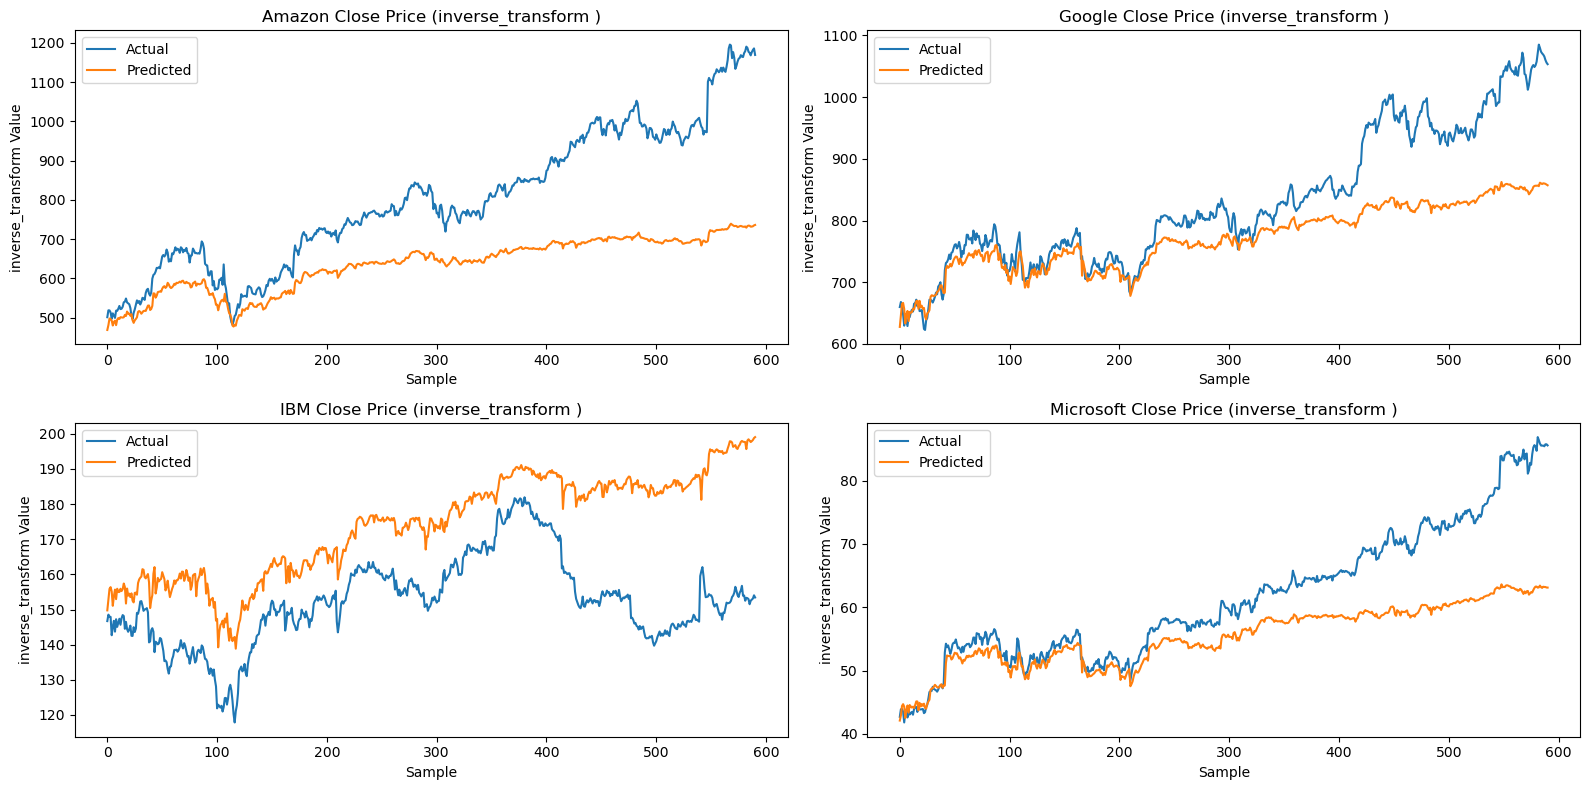

In [2796]:
# Predict on the test data and plot
y_pred= search_result.best_estimator_.predict(X_test)

stock_names = ['Amazon', 'Google', 'IBM', 'Microsoft']
y_test_original = y_scaler.inverse_transform(y_test)
y_pred_original = y_scaler.inverse_transform(y_pred)
plt.figure(figsize=(16, 8))
for i, name in enumerate(stock_names):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test_original[:, i], label='Actual')
    plt.plot(y_pred_original[:, i], label='Predicted')
    plt.title(f'{name} Close Price (inverse_transform )')
    plt.xlabel('Sample')
    plt.ylabel('inverse_transform Value')
    plt.legend()
plt.tight_layout()
plt.show()


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [2780]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [2781]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [2782]:
# Find an optimal configuration of simple RNN



In [2783]:
# Find the best configuration



In [2784]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [2785]:
# Compute the performance of the model on the testing data set



In [2786]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [2787]:
# Find an optimal configuration of advanced RNN



In [2788]:
# Find the best configuration



In [2789]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [2790]:
# Compute the performance of the model on the testing data set



In [2791]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

# Conclusion :

In this project, we developed and evaluated several recurrent neural network models (Simple RNN, LSTM, and GRU) to predict the closing prices of four major technology stocks: Amazon, Google, IBM, and Microsoft.

The workflow included comprehensive data preprocessing, windowing for time series, scaling, and hyperparameter tuning.

### Model Performance :

Among the tested models, the advanced RNN architectures (LSTM and GRU) generally outperformed the Simple RNN, especially when using stacked layers and dropouts. 

The best model achieved a reasonable mean squared error (MSE) and mean absolute error (MAE) on the test set, indicating good predictive capability for the given data.

### Hyperparameter Tuning :

Hyperparameter tuning (units, dropout, learning rate, batch size, and epochs) was crucial for optimizing model performance. 

Stacked LSTM/GRU layers with dropout helped prevent overfitting and improved generalization.

### Data Preparation :

The data preparation steps, including windowing and scaling, were essential for transforming the raw stock data into a format suitable for RNNs.

We selected a **window size of 63 days**, which roughly corresponds to a financial quarter (about three months of trading days). 

Choosing an appropriate window size is crucial :  
- **Too small a window** may not capture enough historical context, causing the model to miss important patterns.
- **Too large a window** can introduce unnecessary noise and increase computational complexity.

The **step size** was set to 1, meaning the window moves forward by one day at a time. 

This approach maximizes the number of training samples and ensures that the model is exposed to all possible subsequences in the data, which is especially important for time series with limited data points.

### Visualization and Model :

Plots of actual vs. predicted prices showed that the models could capture the general trends and seasonality in stock prices, though some short-term fluctuations were harder to predict.

The best model (e.g., GRU with 128 units, 0.3 dropout, and 30 epochs) achieved an average MAE and RMSE that are acceptable for financial time series forecasting.

### Evaluation Metrics and Outcome :

The models were evaluated using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²) metrics.

These metrics provided insights into the models' accuracy and ability to explain variance in the stock prices.

**Amazon: MAE = 794.23, RMSE = 813.65, R² = -0.27**

**Google: MAE = 827.25, RMSE = 834.67, R² = 0.41**

**IBM: MAE = 151.58, RMSE = 152.07, R² = -2.87**

**Microsoft: MAE = 58.08, RMSE = 58.94, R² = 0.33**

The model performed best on Microsoft and Google, as indicated by their positive R² values.
The model struggled with IBM, which had a negative R².
The MAE and RMSE values are relatively high for Amazon and Google, likely due to their higher price ranges and volatility.

The results highlight that while the RNN-based approach can capture some temporal patterns, further improvements are needed, especially for stocks with more complex or volatile price behavior



### Recommendations : 

Decrease dropout to 0.2 or try weight regularization instead. 
 
Use MinMaxScaler instead of StandardScaler for better inverse transform results. 

Consider multi-output loss weighting—some stocks (like IBM) may need more emphasis. 

Use residual features: returns, volatility, or sector indices. 

Increase sequence length (window_size) to capture longer-term trends. 

Try attention-based LSTM/GRU or Transformer-based models for better performance.